In [1]:
import os
cwd = os.getcwd()
os.chdir('..')

import numpy as np
import pandas as pd
# from astropy.io import fits
# from astropy.table import Table
import pickle as pkl
import random

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm.notebook import tqdm

import config
from config import *

from models import *
from helpers_prediction import bin_photon_counts, predict_lightcurve, predict_normalized_spectra, smooth
from helpers_prediction import plotSpecs_freq_domain, plotSpecs_time_domain
from eval_metrics import spectra_rmse, spectra_harnessRatio_rmse, ns3_score
import config_prediction

import subprocess as subp
import multiprocessing
from multiprocessing import Pool
n_cpus = multiprocessing.cpu_count()
print('Num CPU cores:', n_cpus)

import psutil
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('This runtime has {:.1f} gigabytes of available RAM.'.format(ram_gb))
print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')
!nvidia-smi

Num CPU cores: 64
This runtime has 540.6 gigabytes of available RAM.
RAM Used: 12.78 Gb
Sat Mar 23 00:09:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:21:00.0 Off |                    0 |
| N/A   30C    P0              43W / 300W |      4MiB / 81920MiB |      0%      Default |
|                                         |                      |    

## I. Data Preparation
----

There are 2 data to be merge to a single dataframe:
1. `input_features`: 
    * set of input features about the env and telescope condition (e.g: position, day, sunlight, angle, etc)
    * 46 features (excluding `R1`, `TIME`, and `bID`, `FPM_XRAY_PI_xxxx_xxxx`).
    * Input variables description: https://heasarc.gsfc.nasa.gov/lheasoft/ftools/headas/niprefilter2.html
    * We exclude bID since for generalization to new background region.
    * Input feature set:
        * 01 `ROLL [deg]`: pointing axis roll
        * 02 `SAT_LAT [deg]`: sub-satellite latitude (ground-reference)
        * 03 `SAT_LON [deg]`: sub-satellite longitude (ground-reference)
        * 04 `SAT_ALT [km]`: altitude / distance from Earth's center
        * 05 `ELV [deg]`: angle b/w pointing and Earth limb
        * 06 `BR_EARTH [deg]`: angle b/w pointing & bright Earth
        * 07 `SUNSHINE [bool]`: whether there is the Sunlight
        * 08 `TIME_SINCE_SUNSET [s]`: time since sunset
        * 09 `SUN_ANGLE [deg]`: angle between pointing & sun vector
        * 10 `BETA_ANGLE`: 
        * 11 `LOCAL_TIME`: ISS time?
        * 12 `MOON_ANGLE [deg]`: angle between pointing and moon vector
        * 13 `RAM_ANGLE [deg]`: angle between pointing and velocity vector
        * 14 `EAST_ANGLE`:
        * 15 `ANG_DIST [deg]`: angular distance of pointing from nominal
        * 16 `SAA [bool]`: South Atlantic Anomaly
        * 17 `SAA_TIME [s]`: time since entering/exiting SAA
        * 18 `COR_ASCA [GeV/c]`: magnetic cut off rigidity (ASCA map)
        * 19 `COR_SAX [GeV/c]`: magnetic cut off rigidity (ASCA map)
        * 20 `MCILWAIN_L`: McIlwain L parameter (SAX) describing Magnetic Field Lines
        * 21 `MAGFIELD`:
        * 22 `MAGFIELD_MIN`:
        * 23 `MAG_ANGLE`:
        * 24 `AP8MIN`:
        * 25 `AE8MIN`:
        * 26 `ATT_ANG_AZ [deg]`: Pointing azimuth angle
        * 27 `ATT_ANG_EL [deg]`: Pointing elevation angle
        * 28 `FPM_RATIO_REJ_COUNT`: Total PI_RATIO-rejected count
        * (EXCLUDE) 29-34 `FPM_XRAY_PI_xxxx_yyyy`: X-Ray rate at different Energy Spectrums (xxxx to yyyy keV)
        * (EXCLUDE) 35 `FPM_XRAY_PI_COUNT`: total count?
        * 36 `FPM_OVERONLY_COUNT`: Per-FPM over-only reset count from events
        * 37 `FPM_UNDERONLY_COUNT`: Per-FPM under-only reset count from events
        * 38 `FPM_DOUBLE_COUNT`: Per-FPM over+under reset count from events
        * 39 `FPM_FT_COUNT`: Per-FPM Forced Triggered count from events
        * 40 `FPM_NOISE25_COUNT`: Per-FPM noise count <0.25 keV from events
        * 41 `XTI_PNT_JITTER`: Instrument 1-second pointing jitter (NICERV3)
        * 42 `KP`: Potsdam planetary Kp index -> reflect Aurora strength -> Solar Weather activity
        * 43 `SOLAR_PHI [GV]`: Solar modulation potential
        * 44 `COR_NYM [GeV/c]`: Adjusted COR
        * 45 `ANG_DIST_X [arcsec]`: Target position in instrument X coordinates
        * 46 `ANG_DIST_Y [arcsec]`: Target position in instrument X coordinates
2. `data_specs`: 
    * set of X-Ray spectra by bands/channels
    * 1080 X-Ray bands/channels

### 1. Data loading

In [2]:
"""===========================
        1. Load X
==========================="""
try:
    data_features
except:
    """ Load X from CSV file"""
    data_features = pd.read_csv(path_new_features_csv)
    feature_list = list(data_features.columns.astype(str))
    
    """ Assuming indexes between features & specs match and sorted,
        sample only half of the dataset
        -> this is to avoid session crash due to limited RAM
    """
    data_features.drop([i for i in data_features.index if i%2 == 1], inplace=True)
    print('X ready.')
    print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')
    
"""===========================
        2. Load Y
==========================="""
try:
    data_specs
except:
    """ Load Y from CSV file"""
    data_specs = pd.read_csv(path_spec_full_csv, chunksize=10000)
    data_specs = pd.concat(data_specs)
    """ Range of predicted energy channels"""
    spec_list = config.energy_bins
    
    """ Assuming indexes between features & specs match and sorted,
        sample only half of the dataset
        -> this is to avoid session crash due to limited RAM
    """
    data_specs.drop([i for i in data_specs.index if i%2 == 1], inplace=True)
    neg_indexes = data_specs[data_specs.sum(axis=1) < 0].index
    data_specs = data_specs.drop(neg_indexes)
    print('y ready.')
    print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')

"""============================================
    3. Extract only Overlapping X and Y
        -> save memory
============================================"""
overlap_indexes = list(set(set(data_features.index) & set(data_specs.index)))
data_features = data_features.loc[overlap_indexes]
data_specs = data_specs.loc[overlap_indexes]
    
display(data_features)
display(data_specs)
print(data_features.isna().sum().sum())
print(data_specs.isna().sum().sum())

print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')

X ready.
RAM Used: 14.13 Gb
y ready.
RAM Used: 28.5 Gb


TIME      ROLL  SAT_LAT   SAT_LON      SAT_ALT        ELV  \
0        112367256.5  232.4563  37.6229  214.7518  6775.717285  67.261162   
2        112367258.5  232.4951  37.5424  214.8719  6775.738281  67.392433   
4        112367260.5  232.5521  37.4617  214.9916  6775.759766  67.522514   
6        112367262.5  232.5780  37.3809  215.1112  6775.780762  67.654686   
8        112367264.5  232.6412  37.3000  215.2304  6775.802246  67.784668   
...              ...       ...      ...       ...          ...        ...   
3037642  297204522.5   60.4836 -32.1419  166.3270  6797.324219  83.964920   
3037644  297204524.5   60.6628 -32.0539  166.4301  6797.311035  83.931259   
3037646  297204527.5   60.9822 -31.9216  166.5843  6797.291504  83.858940   
3037648  297204529.5   61.1713 -31.8333  166.6868  6797.278320  83.811455   
3037650  297204531.5   61.3351 -31.7449  166.7891  6797.265137  83.762390   

          BR_EARTH  SUNSHINE  TIME_SINCE_SUNSET  SUN_ANGLE  ...     R1   bID  \
0        73.780037       1.0                0.0  90.167892  ...    2.0  b4.2   
2        73.829636       1.0                0.0  90.170227  ...    0.0  b4.2   
4        73.877724       1.0                0.0  90.170227  ...    1.0  b4.2   
6        73.929939       1.0                0.0  90.174042  ...    1.0  b4.2   
8        73.979691       1.0                0.0  90.174934  ...    1.0  b4.2   
...            ...       ...                ...        ...  ...    ...   ...   
3037642  83.964920       1.0                0.0  92.498085  ...   95.0  b5.5   
3037644  83.931259       1.0                0.0  92.492851  ...  110.0  b5.5   
3037646  83.858940       1.0                0.0  92.493797  ...  104.0  b5.5   
3037648  83.811455       1.0                0.0  92.493790  ...   91.0  b5.5   
3037650  83.762390       1.0                0.0  92.491417  ...  104.0  b5.5   

              obsID  FPM_TRUMP_SEL_1500_1800  FPM_RATIO_REJ_300_1800  \
0        1012040102                      0.0                0.000000   
2        1012040102                      0.0                0.000000   
4        1012040102                      0.0                0.000000   
6        1012040102                      0.0                0.017857   
8        1012040102                      0.0                0.000000   
...             ...                      ...                     ...   
3037642  6012050214                      0.0                0.000000   
3037644  6012050214                      0.0                0.000000   
3037646  6012050214                      0.0                0.000000   
3037648  6012050214                      0.0                0.017857   
3037650  6012050214                      0.0                0.000000   

         FPM_SLOW_LLD  MPU_NOISE20_COUNT  MPU_NOISE25_COUNT  \
0            0.725515           8.214286           3.482143   
2            0.725529           8.071429           3.392857   
4            0.725501           7.964286           3.285714   
6            0.725472           7.767857           3.053571   
8            0.725544           7.910714           3.214286   
...               ...                ...                ...   
3037642      0.744405           5.517857           0.071429   
3037644      0.744434           5.767857           0.035714   
3037646      0.744390           5.375000           0.089286   
3037648      0.744419           4.928571           0.071429   
3037650      0.744376           5.589286           0.160714   

         MPU_OVERONLY_COUNT  MPU_UNDERONLY_COUNT  
0                  0.232143             7.857143  
2                  0.178571             7.785714  
4                  0.321429             7.821429  
6                  0.232143             7.767857  
8                  0.232143             7.875000  
...                     ...                  ...  
3037642            0.107143           420.714286  
3037644            0.160714           422.214286  
3037646            0.089286           422.785714 

20  21  22  23  24  25  26  27  28  29  ...  1190  1191  1192  1193  \
0         0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0   
2         0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0   
4         0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0   
6         0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0   
8         0   0   0   0   1   0   0   0   0   0  ...     0     0     0     0   
...      ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   ...   ...   ...   ...   
3037642   0   0   0   0   0   0   0   1   0   0  ...     0     0     0     0   
3037644   0   0   0   0   0   0   0   1   0   0  ...     0     0     0     0   
3037646   0   0   0   0   1   0   1   0   0   0  ...     0     0     0     0   
3037648   0   0   0   0   0   0   0   0   0   1  ...     0     0     0     0   
3037650   0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0   

         1194  1195  1196  1197  1198  1199  
0           0     0     0     0     0     0  
2           0     0     0     0     0     0  
4           0     0     0     0     0     0  
6           0     0     0     0     0     0  
8           0     0     0     0     0     0  
...       ...   ...   ...   ...   ...   ...  
3037642     0     0     0     0     0     0  
3037644     0     0     0     0     0     0  
3037646     0     0     0     0     0     0  
3037648     0     0     0     0     0     0  
3037650     0     0     0     0     0     0  

[1518608 rows x 1180 columns]

0
0
RAM Used: 29.26 Gb


### 2. Merging Data
1. Merge Input Features & Target Photon Counts
2. Merge ObsIDs to Input Features
3. Merge New Input Features

**This is to put X and y indexes in correct order. Initially, they are not in correct order**

In [3]:
"""==========================================================
    4. Merge input features with target photon counts
=========================================================="""
if 'df' not in globals():
    assert (data_features.index == data_specs.index).all()
    
    df = data_features.join(data_specs, rsuffix='spec_') # join on index
    df = df.dropna()
    df.columns = df.columns.astype(str)
    del data_features, data_specs

    """ 3. convert columns to float32 for optimization"""
    for col in tqdm(df.columns):
        if col != 'bID' and col != 'TIME' and col in feature_list:
            df[col] = round(df[col].astype(np.float32), 4)
    print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')
else:
    pass
print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')

"""========================================================== 
    5. Merge Observation IDs to Input Features
        -> add ObsID as a new column
=========================================================="""
if 'obsid_df' not in globals():
    join_features = ['ROLL', 'SAT_LAT', 'SAT_LON']
    position_obs = pd.read_csv('POSITION_OBSID.csv').dropna()

    """ Map Join features to int for merging"""
    for fname in join_features:
        position_obs[fname] = (position_obs[fname] * 1e3).astype(int)
        df[fname] = (df[fname] * 1e3).astype(int)
    """ Merge obsid based on join features"""
    df['orig_index'] = df.index
    obsid_df = pd.merge(position_obs, df[join_features+['orig_index']], on=join_features, how='inner')
    obsid_df.index = obsid_df.orig_index
    """ Map Join features back to float"""
    for fname in join_features:
        df[fname] = (df[fname] / 1e3).astype(float)  
    del position_obs
print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')

"""==========================================================
        6. Split input & target
=========================================================="""
if 'X' not in globals():
    # Extract list of input features
    input_features = config.input_features
    X = df.loc[:, input_features]
    y = df.loc[:, spec_list]
    df_metadata = df.loc[:, ['TIME', 'bID', 'obsID']]
    
    assert len(X) == len(y)
    del df # delete df to save RAM
else:
    assert len(X) == len(y)

display(X)
display(y)


RAM Used: 28.59 Gb
RAM Used: 28.59 Gb
RAM Used: 28.92 Gb


ROLL  SAT_LAT  SAT_LON      SAT_ALT        ELV   BR_EARTH  \
0        232.456   37.622  214.751  6775.717773  67.261200  73.779999   
2        232.495   37.542  214.871  6775.738281  67.392403  73.829597   
4        232.552   37.461  214.991  6775.759766  67.522499  73.877701   
6        232.578   37.380  215.111  6775.780762  67.654701  73.929901   
8        232.641   37.299  215.230  6775.802246  67.784698  73.979698   
...          ...      ...      ...          ...        ...        ...   
3037642   60.483  -32.141  166.326  6797.324219  83.964897  83.964897   
3037644   60.662  -32.053  166.430  6797.311035  83.931297  83.931297   
3037646   60.982  -31.921  166.584  6797.291016  83.858902  83.858902   
3037648   61.171  -31.833  166.686  6797.278320  83.811501  83.811501   
3037650   61.335  -31.744  166.789  6797.264648  83.762398  83.762398   

         SUNSHINE  TIME_SINCE_SUNSET  SUN_ANGLE  BETA_ANGLE  ...  COR_NYM  \
0             1.0                0.0  90.167900   71.304199  ...   5.2875   
2             1.0                0.0  90.170197   71.304298  ...   5.3034   
4             1.0                0.0  90.170197   71.304398  ...   5.3194   
6             1.0                0.0  90.174004   71.304497  ...   5.3355   
8             1.0                0.0  90.174896   71.304497  ...   5.3516   
...           ...                ...        ...         ...  ...      ...   
3037642       1.0                0.0  92.498100   -8.029200  ...   5.1249   
3037644       1.0                0.0  92.492798   -8.029300  ...   5.1580   
3037646       1.0                0.0  92.493797   -8.029400  ...   5.2080   
3037648       1.0                0.0  92.493797   -8.029600  ...   5.2414   
3037650       1.0                0.0  92.491402   -8.029700  ...   5.2718   

         ANG_DIST_X  ANG_DIST_Y  FPM_TRUMP_SEL_1500_1800  \
0         27.885599  -41.483200                      0.0   
2         23.122499  -33.419998                      0.0   
4         24.921499  -30.737301                      0.0   
6         16.367100  -18.738300                      0.0   
8         14.514200  -15.805600                      0.0   
...             ...         ...                      ...   
3037642   -2.849300  -19.498301                      0.0   
3037644    5.719300   22.137699                      0.0   
3037646    1.370400   11.155500                      0.0   
3037648   -0.706500    8.709200                      0.0   
3037650  -15.500200    4.008300                      0.0   

         FPM_RATIO_REJ_300_1800  FPM_SLOW_LLD  MPU_NOISE20_COUNT  \
0                        0.0000        0.7255             8.2143   
2                        0.0000        0.7255             8.0714   
4                        0.0000        0.7255             7.9643   
6                        0.0179        0.7255             7.7679   
8                        0.0000        0.7255             7.9107   
...                         ...           ...                ...   
3037642                  0.0000        0.7444             5.5179   
3037644                  0.0000        0.7444             5.7679   
3037646                  0.0000        0.7444             5.3750   
3037648                  0.0179        0.7444             4.9286   
3037650                  0.0000        0.7444             5.5893   

         MPU_NOISE25_COUNT  MPU_OVERONLY_COUNT  MPU_UNDERONLY_COUNT  
0                   3.4821              0.2321             7.857100  
2                   3.3929              0.1786             7.785700  
4                   3.2857              0.3214             7.821400  
6                   3.0536              0.2321             7.767900  
8                   3.2143              0.2321             7.875000  
...                    ...                 ...                  ...  
3037642             0.0714              0.1071           420.714294  
3037644             0.0357              0.1607           422.214294  
3037646             0.0893              0.

20  21  22  23  24  25  26  27  28  29  ...  1190  1191  1192  1193  \
0         0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0   
2         0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0   
4         0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0   
6         0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0   
8         0   0   0   0   1   0   0   0   0   0  ...     0     0     0     0   
...      ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   ...   ...   ...   ...   
3037642   0   0   0   0   0   0   0   1   0   0  ...     0     0     0     0   
3037644   0   0   0   0   0   0   0   1   0   0  ...     0     0     0     0   
3037646   0   0   0   0   1   0   1   0   0   0  ...     0     0     0     0   
3037648   0   0   0   0   0   0   0   0   0   1  ...     0     0     0     0   
3037650   0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0   

         1194  1195  1196  1197  1198  1199  
0           0     0     0     0     0     0  
2           0     0     0     0     0     0  
4           0     0     0     0     0     0  
6           0     0     0     0     0     0  
8           0     0     0     0     0     0  
...       ...   ...   ...   ...   ...   ...  
3037642     0     0     0     0     0     0  
3037644     0     0     0     0     0     0  
3037646     0     0     0     0     0     0  
3037648     0     0     0     0     0     0  
3037650     0     0     0     0     0     0  

[1518608 rows x 1180 columns]

### 3. Split Train-Val-Test

In [4]:
from config import *
from sklearn.model_selection import train_test_split
seed = 42

"""==========================================================
    7. Split Train-Test set by Backgrounds
=========================================================="""
""" 7.1. Split Train, Val, Test backgrounds"""
list_bgds = df_metadata['bID'].unique()
test_bgds = [bgd for bgd in list_bgds if 'b5' in bgd]
val_bgds = [bgd for bgd in list_bgds if 'b4' in bgd]
train_bgds = [bgd for bgd in list_bgds if bgd not in test_bgds+val_bgds]

print(f'Total backgrounds = {len(list_bgds)}')
print(f'\t Val backgrounds: {val_bgds}')
print(f'\t Test backgrounds: {test_bgds}')
print(f'%Train = {len(train_bgds) / len(list_bgds)}')
print(f'%Train = {len(val_bgds) / len(list_bgds)}')
print(f'%Test = {len(test_bgds) / len(list_bgds)}')

""" 7.2. Split Train, Val, Test {X, y}"""
if 'X_train' not in globals():
    X_train = X[df_metadata['bID'].isin(train_bgds)]
    X_val = X[df_metadata['bID'].isin(val_bgds)]
    X_test = X[df_metadata['bID'].isin(test_bgds)]
    del X # to save RAM
    y_train = y[df_metadata['bID'].isin(train_bgds)]
    y_val = y[df_metadata['bID'].isin(val_bgds)]
    y_test = y[df_metadata['bID'].isin(test_bgds)]
    del y # to save RAM
    train_metadata = df_metadata.loc[X_train.index]
    val_metadata = df_metadata.loc[X_val.index]
    test_metadata = df_metadata.loc[X_test.index]

""" * Investigate Data Quantity"""
print(f'# Training samples = {len(X_train)}.')
print(f'# Training samples = {len(X_val)}.')
print(f'# Testing samples = {len(X_test)}.')
print(X_train.columns)
print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')

Total backgrounds = 39
	 Val backgrounds: ['b4.2', 'b4.3', 'b4.4']
	 Test backgrounds: ['b5.1', 'b5.2', 'b5.3', 'b5.4', 'b5.5']
%Train = 0.7948717948717948
%Train = 0.07692307692307693
%Test = 0.1282051282051282
# Training samples = 1208935.
# Training samples = 123726.
# Testing samples = 185947.
Index(['ROLL', 'SAT_LAT', 'SAT_LON', 'SAT_ALT', 'ELV', 'BR_EARTH', 'SUNSHINE',
       'TIME_SINCE_SUNSET', 'SUN_ANGLE', 'BETA_ANGLE', 'LOCAL_TIME',
       'MOON_ANGLE', 'RAM_ANGLE', 'EAST_ANGLE', 'ANG_DIST', 'SAA', 'SAA_TIME',
       'COR_ASCA', 'COR_SAX', 'MCILWAIN_L', 'MAGFIELD', 'MAGFIELD_MIN',
       'MAG_ANGLE', 'AP8MIN', 'AE8MIN', 'ATT_ANG_AZ', 'ATT_ANG_EL',
       'FPM_RATIO_REJ_COUNT', 'FPM_OVERONLY_COUNT', 'FPM_UNDERONLY_COUNT',
       'FPM_DOUBLE_COUNT', 'FPM_FT_COUNT', 'FPM_NOISE25_COUNT',
       'XTI_PNT_JITTER', 'KP', 'SOLAR_PHI', 'COR_NYM', 'ANG_DIST_X',
       'ANG_DIST_Y', 'FPM_TRUMP_SEL_1500_1800', 'FPM_RATIO_REJ_300_1800',
       'FPM_SLOW_LLD', 'MPU_NOISE20_COUNT', 'MPU_NOI

### 4. Preprocessing: Standardization
1. Compute $\mu$ and $\sigma$ of EACH feature in the training set.
2. Standardization: $x = (x-\mu) / \sigma$
3. Save $\mu$ and $\sigma$ for each feature in a `npz` file for reuse.

In [9]:
"""################################################################
        Execute Standardization Process
################################################################"""
""" 1. Load features' mean and std (computed using X_train)"""
with open(f'{config_prediction.standardize_path}', 'rb') as f:
    feature_mu_sigma = pkl.load(f)

""" 2. Create a new dataset for preprocessed X"""
X_train_processed = X_train.copy()
X_val_processed = X_val.copy()
X_test_processed = X_test.copy()

""" 3. Standardization"""
for fname in tqdm(input_features):
    mu, sigma = feature_mu_sigma[fname]
    X_train_processed[fname] = (X_train[fname] - mu) / (sigma + 1e-3)
    X_val_processed[fname] = (X_val[fname] - mu) / (sigma + 1e-3)
    X_test_processed[fname] = (X_test[fname] - mu) / (sigma + 1e-3)
    
display(X_train_processed[:5])
display(X_val_processed[:5])
display(X_test_processed[:5])

ROLL   SAT_LAT   SAT_LON   SAT_ALT       ELV  BR_EARTH  SUNSHINE  \
1280  0.817364 -0.804571 -1.132263 -1.021830 -1.051379  1.508757 -1.526955   
1282  0.818491 -0.807995 -1.131550 -1.021667 -1.046265  1.508757 -1.526955   
1284  0.819609 -0.811385 -1.130827 -1.021505 -1.041423  1.508757 -1.526955   
1286  0.820638 -0.814809 -1.130114 -1.021343 -1.036357  1.508757 -1.526955   
1288  0.821739 -0.818200 -1.129391 -1.021173 -1.031507  1.508757 -1.526955   

      TIME_SINCE_SUNSET  SUN_ANGLE  BETA_ANGLE  ...   COR_NYM  ANG_DIST_X  \
1280           1.350729  -0.812806    1.197994  ...  1.617296    3.512044   
1282           1.353846  -0.812766    1.197994  ...  1.612356    4.845749   
1284           1.356962  -0.812779    1.197991  ...  1.607372    2.692809   
1286           1.360079  -0.812733    1.197991  ...  1.602324    3.097696   
1288           1.363196  -0.812773    1.197991  ...  1.597234    2.612046   

      ANG_DIST_Y  FPM_TRUMP_SEL_1500_1800  FPM_RATIO_REJ_300_1800  \
1280   -0.980646                -0.051587               -0.389337   
1282   -0.269386                -0.051587               -0.389337   
1284   -0.828791                -0.051587               -0.389337   
1286   -0.218121                -0.051587               -0.389337   
1288   -0.792165                -0.051587               -0.389337   

      FPM_SLOW_LLD  MPU_NOISE20_COUNT  MPU_NOISE25_COUNT  MPU_OVERONLY_COUNT  \
1280     -0.953681          -0.435809          -0.482814           -0.347924   
1282     -0.947627          -0.437739          -0.484127           -0.313871   
1284     -0.953681          -0.430018          -0.477541           -0.279817   
1286     -0.953681          -0.419395          -0.459101           -0.296892   
1288     -0.941573          -0.429051          -0.474907           -0.313871   

      MPU_UNDERONLY_COUNT  
1280            -0.786423  
1282            -0.785675  
1284            -0.785675  
1286            -0.787171  
1288            -0.787546  

[5 rows x 46 columns]

ROLL   SAT_LAT   SAT_LON   SAT_ALT       ELV  BR_EARTH  SUNSHINE  \
0  0.399392  0.575574  0.346052 -1.083174  0.295233 -0.519066  0.637974   
2  0.399738  0.572889  0.347241 -1.083019  0.304107 -0.518269  0.637974   
4  0.400244  0.570170  0.348429 -1.082857  0.312906 -0.517496  0.637974   
6  0.400475  0.567451  0.349618 -1.082698  0.321848 -0.516657  0.637974   
8  0.401034  0.564732  0.350797 -1.082536  0.330641 -0.515857  0.637974   

   TIME_SINCE_SUNSET  SUN_ANGLE  BETA_ANGLE  ...   COR_NYM  ANG_DIST_X  \
0          -0.559774  -0.195667    1.950621  ... -0.419781    2.719662   
2          -0.559774  -0.195592    1.950623  ... -0.416366    2.255574   
4          -0.559774  -0.195592    1.950626  ... -0.412929    2.430858   
6          -0.559774  -0.195466    1.950629  ... -0.409471    1.597368   
8          -0.559774  -0.195437    1.950629  ... -0.406012    1.416833   

   ANG_DIST_Y  FPM_TRUMP_SEL_1500_1800  FPM_RATIO_REJ_300_1800  FPM_SLOW_LLD  \
0   -4.910527                -0.051587               -0.389337     -0.947627   
2   -3.990523                -0.051587               -0.389337     -0.947627   
4   -3.684429                -0.051587               -0.389337     -0.947627   
6   -2.315354                -0.051587                0.949597     -0.947627   
8   -1.980736                -0.051587               -0.389337     -0.947627   

   MPU_NOISE20_COUNT  MPU_NOISE25_COUNT  MPU_OVERONLY_COUNT  \
0          -0.403948          -0.443301           -0.177657   
2          -0.411674          -0.449881           -0.228689   
4          -0.417464          -0.457788           -0.092475   
6          -0.428083          -0.474907           -0.177657   
8          -0.420362          -0.463054           -0.177657   

   MPU_UNDERONLY_COUNT  
0            -0.732552  
2            -0.733300  
4            -0.732926  
6            -0.733486  
8            -0.732364  

[5 rows x 46 columns]

ROLL   SAT_LAT   SAT_LON   SAT_ALT       ELV  BR_EARTH  SUNSHINE  \
29466  0.214664 -0.303436  1.534321 -1.051414  1.068749  1.508757 -1.526955   
29468  0.214283 -0.306826  1.535064 -1.051229  1.077305  1.508757 -1.526955   
29470  0.213883 -0.310183  1.535806 -1.051048  1.085509  1.508757 -1.526955   
29472  0.213768 -0.313539  1.536549 -1.050875  1.094140  1.508757 -1.526955   
29474  0.213395 -0.316930  1.537302 -1.050694  1.102080  1.508757 -1.526955   

       TIME_SINCE_SUNSET  SUN_ANGLE  BETA_ANGLE  ...   COR_NYM  ANG_DIST_X  \
29466           0.781942   1.765994    0.899243  ...  1.381293   -2.259673   
29468           0.785058   1.765961    0.899240  ...  1.382968   -1.195996   
29470           0.788175   1.765964    0.899240  ...  1.384579   -1.358311   
29472           0.791291   1.766001    0.899240  ...  1.386190   -0.807955   
29474           0.794408   1.765899    0.899240  ...  1.386727   -0.482906   

       ANG_DIST_Y  FPM_TRUMP_SEL_1500_1800  FPM_RATIO_REJ_300_1800  \
29466   -4.452841                -0.051587               -0.389337   
29468   -2.923297                -0.051587               -0.389337   
29470   -3.217616                -0.051587               -0.389337   
29472   -1.067566                -0.051587               -0.389337   
29474   -3.081187                -0.051587               -0.389337   

       FPM_SLOW_LLD  MPU_NOISE20_COUNT  MPU_NOISE25_COUNT  MPU_OVERONLY_COUNT  \
29466     -0.947627          -0.447395          -0.495981           -0.262743   
29468     -0.941573          -0.444497          -0.493347           -0.330945   
29470     -0.941573          -0.432911          -0.478861           -0.296892   
29472     -0.947627          -0.427121          -0.469641           -0.279817   
29474     -0.947627          -0.416502          -0.457788           -0.364999   

       MPU_UNDERONLY_COUNT  
29466            -0.788107  
29468            -0.786611  
29470            -0.786797  
29472            -0.786049  
29474            -0.786423  

[5 rows x 46 columns]

## II. Evaluation
----

### 1. Load data to Tensor and load SCORPEON prediction for test set

In [10]:
"""==============================================================
        LOAD PREDICTIONS FOR TEST BKGD FROM SCORPEON MODEL
=============================================================="""
try:
    scorp_specs
except:
    # 1. Load SCORPEON's predictions from CSV file
    scorp_specs = pd.read_csv('/group/wanglei/data/QG_outputs/spec_bgd_5_sc.csv')
    # 2. Set appropriate index for INDEX matching
    scorp_specs.set_index('Unnamed: 0', inplace=True)
    # 3. Extract energy bins 0.2 - 12 keV only
    scorp_specs = scorp_specs[spec_list]
    # 4. Rename index column and sort
    scorp_specs.index.names = [None]
    scorp_specs.sort_index(inplace=True)
    # 5. Normalize the photon counts by 1e9 (for SCORPEON outputs)
    scorp_specs = scorp_specs / 1e9
    # (NO NEED) 6. Adjust index due to errors while running numerical model
    # scorp_specs.index = scorp_specs.index+1
    
display(scorp_specs)
print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')

20         21        22        23        24        25  \
29465     0.040510   0.056799  0.075952  0.097084  0.118858  0.139733   
29466     0.037216   0.010535  0.003971  0.002879  0.003051  0.003445   
29467     0.036838   0.010428  0.003945  0.002873  0.003050  0.003444   
29468     0.037200   0.010531  0.003970  0.002878  0.003050  0.003444   
29469     0.037132   0.010512  0.003965  0.002877  0.003050  0.003444   
...            ...        ...       ...       ...       ...       ...   
3036017  13.603979   7.669355  4.030811  1.975499  0.903478  0.386351   
3036018  18.677780  10.832927  5.872637  2.976148  1.410556  0.625937   
3036019  13.278701   7.502732  3.952357  1.941678  0.890208  0.381656   
3036020  12.451139   6.866459  3.524814  1.684823  0.750537  0.312401   
3036021  10.454516   5.710394  2.900524  1.370583  0.603173  0.248047   

               26        27        28        29  ...      1190      1191  \
29465    0.158358  0.173939  0.186404  0.196246  ...  0.000961  0.000960   
29466    0.003819  0.004127  0.004352  0.004501  ...  0.000179  0.000179   
29467    0.003819  0.004126  0.004352  0.004501  ...  0.000179  0.000179   
29468    0.003819  0.004126  0.004352  0.004501  ...  0.000179  0.000179   
29469    0.003818  0.004126  0.004351  0.004500  ...  0.000179  0.000179   
...           ...       ...       ...       ...  ...       ...       ...   
3036017  0.155392  0.059822  0.023174  0.010154  ...  0.000138  0.000138   
3036018  0.260902  0.103109  0.039701  0.016007  ...  0.000134  0.000134   
3036019  0.153918  0.059425  0.023089  0.010143  ...  0.000138  0.000138   
3036020  0.122453  0.046281  0.018028  0.008342  ...  0.000138  0.000137   
3036021  0.096293  0.036386  0.014547  0.007204  ...  0.000138  0.000138   

             1192      1193      1194      1195      1196      1197      1198  \
29465    0.000959  0.000959  0.000958  0.000957  0.000956  0.000955  0.000954   
29466    0.000179  0.000179  0.000179  0.000178  0.000178  0.000178  0.000177   
29467    0.000179  0.000179  0.000179  0.000178  0.000178  0.000178  0.000177   
29468    0.000179  0.000179  0.000179  0.000178  0.000178  0.000178  0.000177   
29469    0.000179  0.000179  0.000179  0.000178  0.000178  0.000178  0.000177   
...           ...       ...       ...       ...       ...       ...       ...   
3036017  0.000137  0.000137  0.000137  0.000137  0.000137  0.000136  0.000136   
3036018  0.000134  0.000134  0.000134  0.000133  0.000133  0.000133  0.000132   
3036019  0.000138  0.000137  0.000137  0.000137  0.000137  0.000136  0.000136   
3036020  0.000137  0.000137  0.000137  0.000137  0.000136  0.000136  0.000136   
3036021  0.000138  0.000137  0.000137  0.000137  0.000137  0.000136  0.000136   

             1199  
29465    0.000954  
29466    0.000177  
29467    0.000177  
29468    0.000177  
29469    0.000177  
...           ...  
3036017  0.000136  
3036018  0.000132  
3036019  0.000136  
3036020  0.000136  
3036021  0.000136  

[100574 rows x 1180 columns]

RAM Used: 29.79 Gb


In [11]:
"""==============================================================
        CONVERT TRAIN / VAL / TEST SETS TO TORCH.TENSOR
=============================================================="""
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

""" 1. Tensor conversion"""
TensorX_train = torch.Tensor(np.array(X_train_processed))
TensorX_val = torch.Tensor(np.array(X_val_processed))
TensorX_test = torch.Tensor(np.array(X_test_processed))
Tensory_train = torch.Tensor(np.array(y_train))
Tensory_val = torch.Tensor(np.array(y_val))
Tensory_test = torch.Tensor(np.array(y_test))

print(f'Training data = {len(Tensory_train)} | Shape = {TensorX_train.shape}, {Tensory_train.shape}')
print(f'Validation data = {len(Tensory_val)} | Shape = {TensorX_val.shape}, {Tensory_val.shape}')
print(f'Testing data = {len(Tensory_test)} | Shape = {TensorX_test.shape}, {Tensory_test.shape}')
print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')

cuda
Training data = 1208935 | Shape = torch.Size([1208935, 46]), torch.Size([1208935, 1180])
Validation data = 123726 | Shape = torch.Size([123726, 46]), torch.Size([123726, 1180])
Testing data = 185947 | Shape = torch.Size([185947, 46]), torch.Size([185947, 1180])
RAM Used: 37.46 Gb


### 2. load trained *Stage 1* model (per channel photon counts) and *Stage 2* model (spectra clustering)

In [18]:
"""==========================================================
        1. Load trained Stage 1 model
            Photon count prediction for
            each channel
============================================================"""
dnn_weight_path = './DNN_weights'
# dnn = torch.load(f'{dnn_weight_path}/linear.pt')
# dnn = torch.load(f'{dnn_weight_path}/dnn_full_bkgd_v4_t5_46features_v1.pt', map_location=torch.device(device))
# dnn = torch.load(f'{dnn_weight_path}/dnn_full_bkgd_v4_t5_46features_v2.pt', map_location=torch.device(device))
# dnn = torch.load(f'{dnn_weight_path}/dnn_full_bkgd_v4_t5_46features_v3.pt', map_location=torch.device(device))
# dnn = torch.load(f'{dnn_weight_path}/dnn_freq_reduced_v4_t5_46features_v1.pt', map_location=torch.device(device))

# dnn = torch.load(f'{dnn_weight_path}/resnet4_full_bkgd_v4_t5_46features_v2.pt', map_location=torch.device(device))
# dnn = torch.load(f'{dnn_weight_path}/resnet4_full_bkgd_v4_t5_46features_v3.pt', map_location=torch.device(device))
# dnn = torch.load(f'{dnn_weight_path}/resnet4_full_bkgd_v4_t5_46features_v4.pt', map_location=torch.device(device))

# dnn = torch.load(f'{dnn_weight_path}/resnet_freq_reduced_v4_t5_46features_v1.pt', map_location=torch.device(device))
# dnn = torch.load(f'{dnn_weight_path}/resnet_freq_reduced_v4_t5_46features_v2.pt', map_location=torch.device(device))
dnn = torch.load(f'{dnn_weight_path}/resnet_freq_reduced_v4_t5_46features_v3.pt', map_location=torch.device(device))

# dnn = torch.load(f'{dnn_weight_path}/bertx4_freq_reduced_v4_t5_46features_v1.pt', map_location=torch.device(device))
# dnn = torch.load(f'{dnn_weight_path}/bertx4_freq_reduced_v4_t5_46features_v2.pt', map_location=torch.device(device))
# dnn = torch.load(f'{dnn_weight_path}/bertx4_freq_reduced_v4_t5_46features_v3.pt', map_location=torch.device(device))

dnn = dnn.to(device)
dnn.eval()
# criterion = MSLELoss()

"""==========================================================
        2. Load trained Stage 2 model
            Spectra clustering and 
            spectra library
=========================================================="""
cluster_saveDir = 'cluster_model/2levels'
n_clusters = 10 # 15
ver = 'v2' # 'v3'

# load energy bin group used to train the cluster model
with open(f"{cluster_saveDir}/kmeans_ebins_lvl1.pkl", "rb") as f:
    kmeans_ebins = pkl.load(f)
with open(f"{cluster_saveDir}/kmeans_ebins_lvl2.pkl", "rb") as f:
    kmeans_ebins_2 = pkl.load(f)

# load trained cluster model
with open(f"{cluster_saveDir}/kmeans_k1={n_clusters}_k2=dynamic_lvl1_{ver}.pkl", "rb") as f:
    model_cluster = pkl.load(f)
with open(f"{cluster_saveDir}/kmeans_k1={n_clusters}_k2=dynamic_lvl2_{ver}.pkl", "rb") as f:
    models_cluster_2 = pkl.load(f)
    
# load spectra library for each cluster
with open(f"{cluster_saveDir}/spec_library_k={n_clusters}_2lvls_{ver}.pkl", "rb") as f:
    spec_library = pkl.load(f)

### 3.1. Quantitative Evaluation: Light Curve Prediction
1. Total photon counts: $MSLE$ and $R^2$
2. Total photon counts: $RMSE$ for different level of brightness

In [13]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

"""######################################
    Scatter plot density (linear scale)
######################################"""
""" 1a.  Run Predictions for Test set"""
preds = []
eval_bs = 128
for batch in tqdm(range(0, len(TensorX_test), eval_bs)):
    yhat = dnn(TensorX_test[batch:batch+eval_bs].to(device))
    preds.append(yhat)  
preds = torch.concat(preds, axis=0).cpu()
preds = preds.detach().cpu().numpy()

""" 1b. Aggregate total photon counts across all channels (brightness)"""
total_count_preds = preds.sum(axis=1)
total_count_targets = Tensory_test.sum(axis=1).detach().cpu().numpy()
max_count = max(total_count_targets)

""" 2. Scatter plot"""
plt.figure(figsize=(9,9))
plt.title('Total Photon Counts\n($0.2keV$ to $12keV$)', fontsize=20)
plt.scatter(total_count_preds, total_count_targets, alpha=0.2)
plt.plot([0, max_count], [0, max_count], '--', color='red')

plt.xlabel('Estimated Total Photon Counts\n($cts/s/10eV$)', fontsize=16)
plt.ylabel('Observed Total Photon Counts\n($cts/s/10eV$)', fontsize=16)

r2 = r2_score(total_count_targets, total_count_preds)
err = mean_squared_log_error(total_count_targets, total_count_preds)
R2line = f'$R^2$ = {round(r2,2)}'
MSLEline = f'$MSLE$ = {round(float(err),3)}'
plt.plot([], [], ' ', label=R2line)
plt.plot([], [], ' ', label=MSLEline)
plt.legend(fontsize=16)

print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')


RAM Used: 42.0 Gb


Overall
Num samples:  50252
	 RMSE(SCORPEON): 754.6179
	 RMSE(DL) 122.3888
	 R2(SCORPEON): 0.0306
	 R2(DL) 0.9745
	 ----------------------------------------
Case 1: total counts in >= 1000
Num samples:  319
	 RMSE(SCORPEON): 9466.678
	 RMSE(DL) 1517.9074
	 R2(SCORPEON): -1.7409
	 R2(DL) 0.9295
	 ----------------------------------------
Case 2: total counts in [100, 1000]
Num samples:  553
	 RMSE(SCORPEON): 208.976
	 RMSE(DL) 168.3598
	 R2(SCORPEON): 0.1672
	 R2(Resnet) 0.4595
	 ----------------------------------------
Case 3: total counts in [10, 100]
Num samples:  14509
	 RMSE(SCORPEON): 14.4356
	 RMSE(DL) 10.2826
	 R2(SCORPEON): 0.1507
	 R2(DL) 0.5691
	 ----------------------------------------
Case 4: total counts < 10
Num samples:  34871
	 RMSE(SCORPEON): 4.146
	 RMSE(DL) 3.8874
	 R2(SCORPEON): -1.2449
	 R2(DL) -0.9736
	 ----------------------------------------


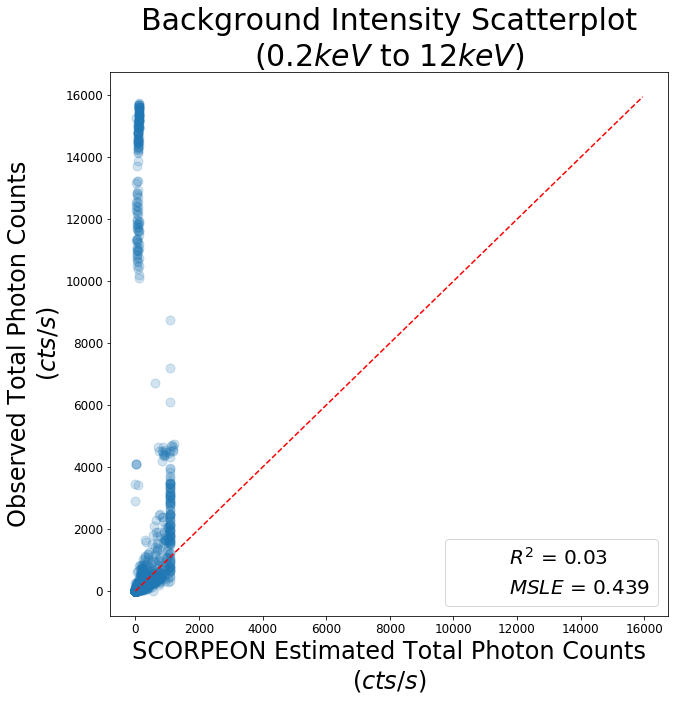

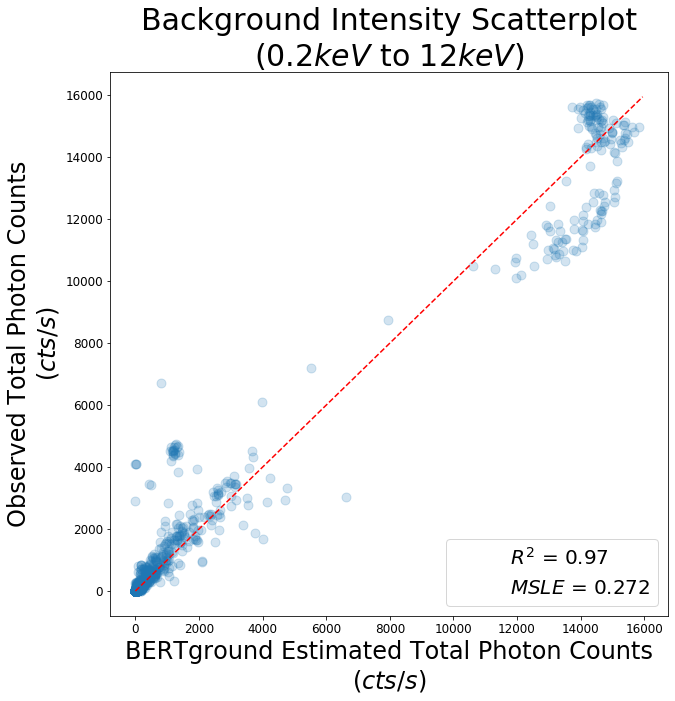

In [23]:
"""##############################################
    Scatter Plot for Total Photon Counts
##############################################"""
"""-------------------------------------------
    Scatter plot density (DNN linear scale)
-------------------------------------------"""
print('Overall')
tot_counts = y_test.sum(axis=1)
indexes = [i for i in y_test.index if i in scorp_specs.index]
total_count_targets = y_test.loc[indexes].sum(axis=1)
total_count_preds = scorp_specs.loc[indexes].sum(axis=1)

plt.figure(figsize=(10,10))
plt.title('Background Intensity Scatterplot\n($0.2keV$ to $12keV$)', fontsize=30)
plt.scatter(total_count_preds, total_count_targets, s=80, alpha=0.2)
plt.plot([0, max_count], [0, max_count], '--', color='red')
plt.xlabel('SCORPEON Estimated Total Photon Counts\n($cts/s$)', fontsize=24)
plt.ylabel('Observed Total Photon Counts\n($cts/s$)', fontsize=24)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
r2 = r2_score(total_count_targets, total_count_preds)
err = mean_squared_log_error(total_count_targets, total_count_preds)
R2line = f'$R^2$ = {round(r2,2)}'
MSLEline = f'$MSLE$ = {round(float(err),3)}'
plt.plot([], [], ' ', label=R2line)
plt.plot([], [], ' ', label=MSLEline)
plt.legend(fontsize=20, loc='lower right')
"""-------------------------------------------
    Scatter plot density (SCORPEON linear scale)
-------------------------------------------"""
indexes = [i for i in y_test.index if i in scorp_specs.index]
indexes_iloc = y_test.reset_index()[y_test.reset_index()['index'].isin(indexes)].index
total_count_targets = y_test.loc[indexes].sum(axis=1)
total_count_preds = preds[indexes_iloc].sum(axis=1)

plt.figure(figsize=(10,10))
plt.title('Background Intensity Scatterplot\n($0.2keV$ to $12keV$)', fontsize=30)
plt.scatter(total_count_preds, total_count_targets, s=80, alpha=0.2)
plt.plot([0, max_count], [0, max_count], '--', color='red')
plt.xlabel('BERTground Estimated Total Photon Counts\n($cts/s$)', fontsize=24)
plt.ylabel('Observed Total Photon Counts\n($cts/s$)', fontsize=24)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
r2 = r2_score(total_count_targets, total_count_preds)
err = mean_squared_log_error(total_count_targets, total_count_preds)
R2line = f'$R^2$ = {round(r2,2)}'
MSLEline = f'$MSLE$ = {round(float(err),3)}'
plt.plot([], [], ' ', label=R2line)
plt.plot([], [], ' ', label=MSLEline)
plt.legend(fontsize=20, loc='lower right')

"""##############################################
    Errors of Total Photon Counts for 
    each subcase:
        1) very bright: >= 1000 photon cts
        2) bright:  [100, 1000] photon cts
        3) faint:     [10, 100] photon cts
        4) very faint: < 10 photon cts
##############################################"""
# b. Compute Error
err = {}
r2 = {}
err['sc'] = mean_squared_error(y_test.loc[indexes].sum(axis=1), scorp_specs.loc[indexes].sum(axis=1))**0.5
err['ml'] = mean_squared_error(y_test.iloc[indexes_iloc].sum(axis=1), preds[indexes_iloc].sum(axis=1))**0.5
r2['sc'] = r2_score(y_test.loc[indexes].sum(axis=1), scorp_specs.loc[indexes].sum(axis=1))
r2['ml'] = r2_score(y_test.iloc[indexes_iloc].sum(axis=1), preds[indexes_iloc].sum(axis=1))

print('Num samples: ', len(indexes))
print('\t RMSE(SCORPEON):', round(err['sc'], 4))
print('\t RMSE(DL)', round(err['ml'], 4))
print('\t R2(SCORPEON):', round(r2['sc'], 4))
print('\t R2(DL)', round(r2['ml'], 4))
print('\t', '-'*40)


"""##############################################
    Case 1: total counts >= 1000
##############################################"""
print('Case 1: total counts in >= 1000')
# a. Extract both .loc and .iloc indexes (we have both pd.dataframe & np.array)
indexes = [i for i in y_test[tot_counts >= 1000].index if i in scorp_specs.index]
indexes_iloc = y_test.reset_index()[y_test.reset_index()['index'].isin(indexes)].index

# b. Compute Error
err = {}
r2 = {}
err['sc'] = mean_squared_error(y_test.loc[indexes].sum(axis=1), scorp_specs.loc[indexes].sum(axis=1))**0.5
err['ml'] = mean_squared_error(y_test.iloc[indexes_iloc].sum(axis=1), preds[indexes_iloc].sum(axis=1))**0.5
r2['sc'] = r2_score(y_test.loc[indexes].sum(axis=1), scorp_specs.loc[indexes].sum(axis=1))
r2['ml'] = r2_score(y_test.iloc[indexes_iloc].sum(axis=1), preds[indexes_iloc].sum(axis=1))

print('Num samples: ', len(indexes))
print('\t RMSE(SCORPEON):', round(err['sc'], 4))
print('\t RMSE(DL)', round(err['ml'], 4))
print('\t R2(SCORPEON):', round(r2['sc'], 4))
print('\t R2(DL)', round(r2['ml'], 4))
print('\t', '-'*40)


"""##############################################
    Case 2: total counts in [100, 1000]
##############################################"""
print('Case 2: total counts in [100, 1000]')
# a. Extract both .loc and .iloc indexes (we have both pd.dataframe & np.array)
indexes = [i for i in y_test[(tot_counts >= 100) & (tot_counts < 1000)].index if i in scorp_specs.index]
indexes_iloc = y_test.reset_index()[y_test.reset_index()['index'].isin(indexes)].index

# b. Compute Error
err = {}
r2 = {}
err['sc'] = mean_squared_error(y_test.loc[indexes].sum(axis=1), scorp_specs.loc[indexes].sum(axis=1))**0.5
err['ml'] = mean_squared_error(y_test.iloc[indexes_iloc].sum(axis=1), preds[indexes_iloc].sum(axis=1))**0.5
r2['sc'] = r2_score(y_test.loc[indexes].sum(axis=1), scorp_specs.loc[indexes].sum(axis=1))
r2['ml'] = r2_score(y_test.iloc[indexes_iloc].sum(axis=1), preds[indexes_iloc].sum(axis=1))

print('Num samples: ', len(indexes))
print('\t RMSE(SCORPEON):', round(err['sc'], 4))
print('\t RMSE(DL)', round(err['ml'], 4))
print('\t R2(SCORPEON):', round(r2['sc'], 4))
print('\t R2(Resnet)', round(r2['ml'], 4))
print('\t', '-'*40)

"""##############################################
    Case 3: total counts in [100, 1000]
##############################################"""
print('Case 3: total counts in [10, 100]')
# a. Extract both .loc and .iloc indexes (we have both pd.dataframe & np.array)
indexes = [i for i in y_test[(tot_counts >= 10) & (tot_counts < 100)].index if i in scorp_specs.index]
indexes_iloc = y_test.reset_index()[y_test.reset_index()['index'].isin(indexes)].index

# b. Compute Error
err = {}
r2 = {}
err['sc'] = mean_squared_error(y_test.loc[indexes].sum(axis=1), scorp_specs.loc[indexes].sum(axis=1))**0.5
err['ml'] = mean_squared_error(y_test.iloc[indexes_iloc].sum(axis=1), preds[indexes_iloc].sum(axis=1))**0.5
r2['sc'] = r2_score(y_test.loc[indexes].sum(axis=1), scorp_specs.loc[indexes].sum(axis=1))
r2['ml'] = r2_score(y_test.iloc[indexes_iloc].sum(axis=1), preds[indexes_iloc].sum(axis=1))

print('Num samples: ', len(indexes))
print('\t RMSE(SCORPEON):', round(err['sc'], 4))
print('\t RMSE(DL)', round(err['ml'], 4))
print('\t R2(SCORPEON):', round(r2['sc'], 4))
print('\t R2(DL)', round(r2['ml'], 4))
print('\t', '-'*40)

"""##############################################
    Case 4: total counts < 10
##############################################"""
print('Case 4: total counts < 10')
# a. Extract both .loc and .iloc indexes (we have both pd.dataframe & np.array)
indexes = [i for i in y_test[(tot_counts < 10)].index if i in scorp_specs.index]
indexes_iloc = y_test.reset_index()[y_test.reset_index()['index'].isin(indexes)].index

# b. Compute Error
err = {}
r2 = {}
err['sc'] = mean_squared_error(y_test.loc[indexes].sum(axis=1), scorp_specs.loc[indexes].sum(axis=1))**0.5
err['ml'] = mean_squared_error(y_test.iloc[indexes_iloc].sum(axis=1), preds[indexes_iloc].sum(axis=1))**0.5
r2['sc'] = r2_score(y_test.loc[indexes].sum(axis=1), scorp_specs.loc[indexes].sum(axis=1))
r2['ml'] = r2_score(y_test.iloc[indexes_iloc].sum(axis=1), preds[indexes_iloc].sum(axis=1))

print('Num samples: ', len(indexes))
print('\t RMSE(SCORPEON):', round(err['sc'], 4))
print('\t RMSE(DL)', round(err['ml'], 4))
print('\t R2(SCORPEON):', round(r2['sc'], 4))
print('\t R2(DL)', round(r2['ml'], 4))
print('\t', '-'*40)

### 3.2. Quantitative Evaluation: Normalized Spectra

In [19]:
""" list of ObsID in test set"""
test_indexes = [i for i in y_test.index if i in obsid_df.index]
test_obsid_df = obsid_df.loc[test_indexes]
obsid_list = test_obsid_df.obsID.unique()

"""==================================================
        Iterate through each ObsID 
        to compute normalized spectra
=================================================="""
all_specs_gt = []
all_specs_scorps = []
all_specs_preds = []

for obsid in tqdm(obsid_list, desc='compute normalized spectra for each ObsID'):
    # 1. Get .loc indexes of obsid
    indexes = test_obsid_df[test_obsid_df['obsID'] == obsid].index
    indexes = [idx for idx in indexes if idx in scorp_specs.index]
    
    # ignore ObsID with fewer than 60 observations
    if len(indexes) < 60: 
        continue
        
    # 2b. Get .iloc indexes of obsid
    #     + create new test_obsid_df
    #     + create new column call 'iloc_index'
    X_test_iloc = X_test.copy()
    X_test_iloc['index_iloc'] = X_test_iloc.reset_index().index
    indexes_iloc = list(X_test_iloc.loc[indexes]['index_iloc'])

    ########################################################
    # 3. Compute normalized spectra from extracted ObsID
    ########################################################
    obsid_specs_gt = y_test.loc[indexes].mean(axis=0)
    obsid_specs_gt_std = y_test.loc[indexes].std(axis=0)
    obsid_specs_scorps = scorp_specs.loc[indexes].mean(axis=0)
    obsid_specs_preds = predict_normalized_spectra(dnn, 
                                                   X=TensorX_test[indexes_iloc].to(device), 
                                                   model_cluster=model_cluster, 
                                                   models_cluster_2=models_cluster_2,
                                                   cluster_ebins=kmeans_ebins, 
                                                   cluster_ebins_2=kmeans_ebins_2,
                                                   spec_library=spec_library)
   
    # raw prediction without spec_cluster
    # obsid_specs_preds = dnn(TensorX_test[indexes_iloc].to(device)).detach().cpu().numpy().mean(axis=0)
    
    ########################################################
    # 4. record normalized spectra for each ObsID
    #     + ground-truth normalized spectra
    #     + SCORPEON normalized spectra
    #     + ML predicted normalized spectra
    ########################################################
    all_specs_gt.append(obsid_specs_gt)
    all_specs_scorps.append(obsid_specs_scorps)
    all_specs_preds.append(obsid_specs_preds)
    
"""==================================================
        Compute normalized spectra loss
=================================================="""
all_specs_gt = np.array(all_specs_gt)
all_specs_scorps = np.array(all_specs_scorps)
all_specs_preds = np.array(all_specs_preds)

spec_err = {}
# evaluation: root-mean-squared-error
spec_err['sc (rmse)'] = spectra_rmse(all_specs_gt, all_specs_scorps)
spec_err['ml (rmse)'] = spectra_rmse(all_specs_gt, all_specs_preds)
# evaluation: n3 similarity score
spec_err['sc (n3)'] = ns3_score(all_specs_gt, all_specs_scorps)
spec_err['ml (n3)'] = ns3_score(all_specs_gt, all_specs_preds)
# # evaluation: hardness ratio rmse
# # faint_bkgds = np.where(all_specs_gt.sum(axis=1) < 20)
# spec_err['sc (HR rmse)'] = spectra_harnessRatio_rmse(all_specs_gt[:], all_specs_scorps[:])
# spec_err['ml (HR rmse)'] = spectra_harnessRatio_rmse(all_specs_gt[:], all_specs_preds[:])

print('1a. Root MSE -> pure mean error \n(lower the better):')
print('\t SCORPEON (Normalized Spectra):', spec_err['sc (rmse)'])
print('\t ML (Normalized Spectra):', spec_err['ml (rmse)'])\
#
print('2. N3 Similarity Score (error + shape)\n(lower the better -> stronger match):')
print('\t SCORPEON (Normalized Spectra):', spec_err['sc (n3)'])
print('\t ML (Normalized Spectra):', spec_err['ml (n3)'])
# #
# print('3. Hardness Ratio Root MSE -> mean error of Hardness Ratios \n(lower the better):')
# print('\t SCORPEON (Normalized Spectra):', spec_err['sc (HR rmse)'])
# print('\t ML (Normalized Spectra):', spec_err['ml (HR rmse)'])


1a. Root MSE -> pure mean error 
(lower the better):
	 SCORPEON (Normalized Spectra): 0.5668061931291187
	 ML (Normalized Spectra): 0.37695177601698826
2. N3 Similarity Score (error + shape)
(lower the better -> stronger match):
	 SCORPEON (Normalized Spectra): 0.7295501177404241
	 ML (Normalized Spectra): 0.5340723840439462
3. Hardness Ratio Root MSE -> mean error of Hardness Ratios 
(lower the better):
	 SCORPEON (Normalized Spectra): 0.16739006490707353
	 ML (Normalized Spectra): 0.17689638778949604


In [ ]:
# faint_bkgds = np.where(all_specs_gt.sum(axis=1) < 20)

# # evaluation: root-mean-squared-error
# spec_err['sc (rmse)'] = spectra_rmse(all_specs_gt[faint_bkgds], all_specs_scorps[faint_bkgds])
# spec_err['ml (rmse)'] = spectra_rmse(all_specs_gt[faint_bkgds], all_specs_preds[faint_bkgds])
# # evaluation: n3 similarity score
# spec_err['sc (n3)'] = ns3_score(all_specs_gt[faint_bkgds], all_specs_scorps[faint_bkgds])
# spec_err['ml (n3)'] = ns3_score(all_specs_gt[faint_bkgds], all_specs_preds[faint_bkgds])
# # # evaluation: hardness ratio rmse
# # spec_err['sc (HR rmse)'] = spectra_harnessRatio_rmse(all_specs_gt[faint_bkgds], all_specs_scorps[faint_bkgds])
# # spec_err['ml (HR rmse)'] = spectra_harnessRatio_rmse(all_specs_gt[faint_bkgds], all_specs_preds[faint_bkgds])

# print('1a. Root MSE -> pure mean error \n(lower the better):')
# print('\t SCORPEON (Normalized Spectra):', spec_err['sc (rmse)'])
# print('\t ML (Normalized Spectra):', spec_err['ml (rmse)'])
# print('2. N3 Similarity Score (error + shape)\n(lower the better -> stronger match):')
# print('\t SCORPEON (Normalized Spectra):', spec_err['sc (n3)'])
# print('\t ML (Normalized Spectra):', spec_err['ml (n3)'])

In [ ]:
# max_count = max(all_specs_gt.max(), all_specs_scorps.max())
# print(torch.nn.PoissonNLLLoss()(torch.Tensor((all_specs_gt / max_count).astype(int)), 
#                                 torch.Tensor((all_specs_scorps / max_count).astype(int))))
# print(nn.PoissonNLLLoss()(torch.Tensor([[0]]), torch.Tensor([[0]])))

### 4. Qualitative Evaluation
1. ObsID normalized spectra
2. ObsID light curve prediction

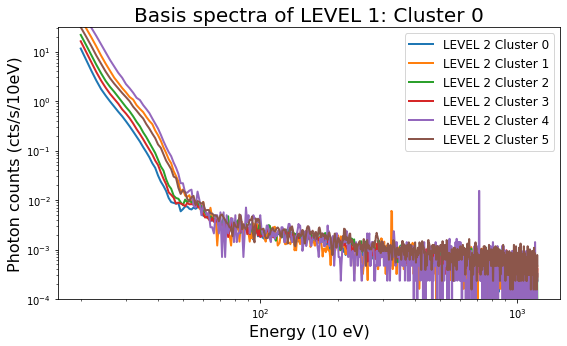

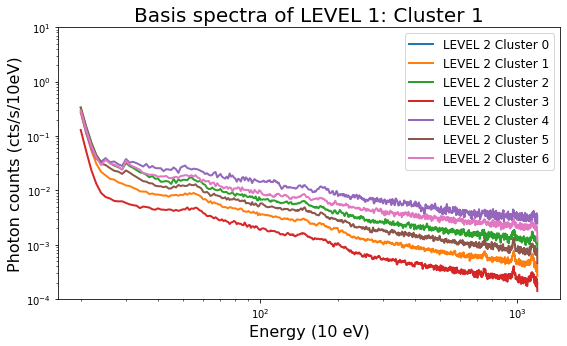

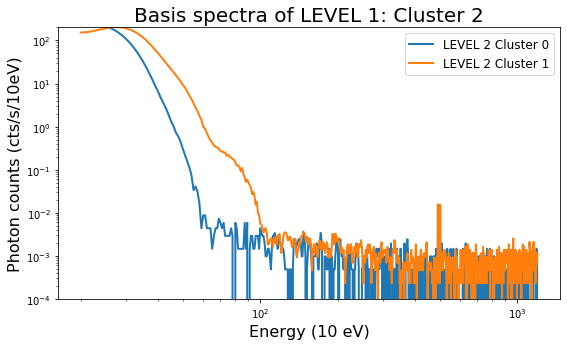

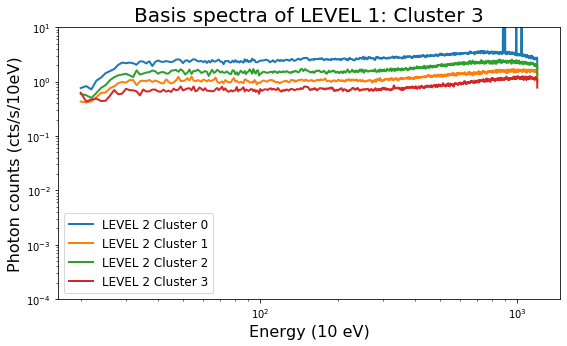

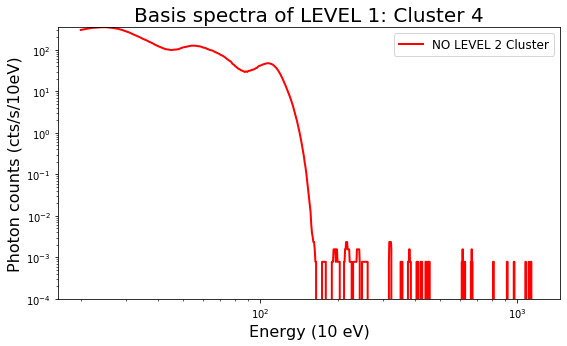

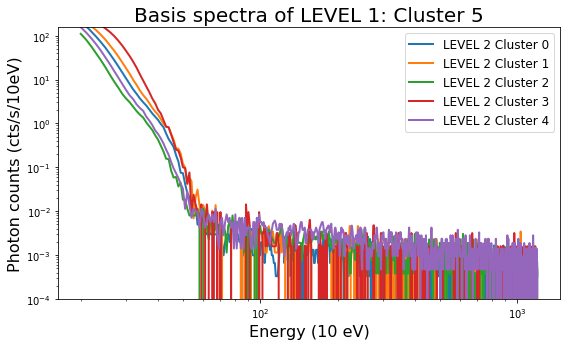

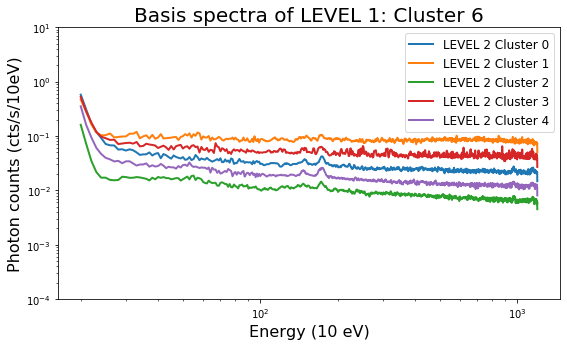

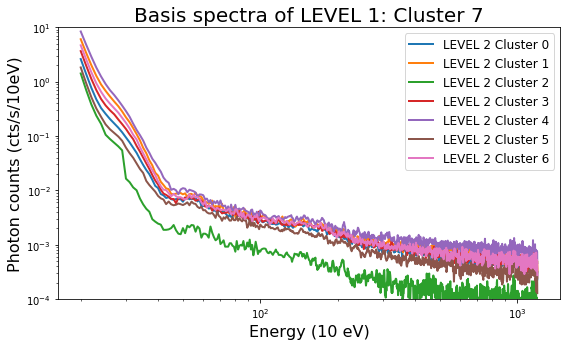

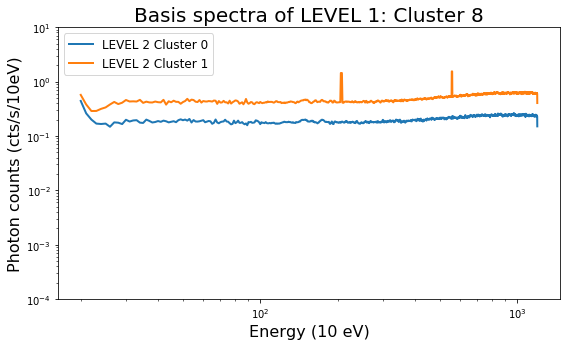

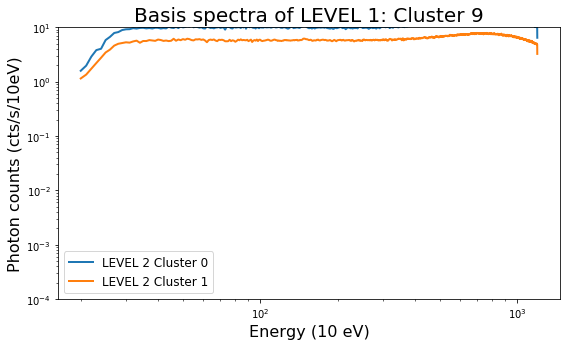

In [20]:
"""#################################################
        Construct spectra library by 
        computing normalized spectra 
        of different clusters defined by 
        trained k-means clustering
#################################################"""
""" 
    Visualize spectra cluster centroids from spec_library
        spec_libary[brightness][k] = normalized spectra of cluster k-th 
                                     for specified`brightness` level
"""
""" 3. energy bins"""
ebins = list(y_train.columns.astype(int))

for cluster_id in tqdm(range(len(model_cluster.cluster_centers_)), 
                       desc='compute normalized spectra of different clusters'):
    """ get the cluster normalized spectra"""
    plt.figure(figsize=(9,5))
    plt.title(f'Basis spectra of LEVEL 1: Cluster {cluster_id}', fontsize=20)
    
    # """ Case 1: NO LEVEL 2 CLUSTERING """
    if not isinstance(spec_library[cluster_id], dict):
        cluster_spec = spec_library[cluster_id]
        plt.plot(ebins, cluster_spec, linewidth=2, label='NO LEVEL 2 Cluster', color='red')
    else: 
    # """ Case 2: LEVEL 2 CLUSTERING """
        for cluster_id_2 in spec_library[cluster_id]:
            cluster_spec = spec_library[cluster_id][cluster_id_2]
            """ plot the cluster spec"""
            plt.plot(ebins, cluster_spec, linewidth=2, label='LEVEL 2 Cluster ' + str(cluster_id_2))
    
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('Photon counts (cts/s/10eV)', fontsize=16)
    plt.xlabel('Energy (10 eV)', fontsize=16)
    plt.ylim([1e-4, max(10, cluster_spec.max())])
    plt.legend(fontsize=12)
    plt.show()

In [ ]:
# plt.figure()
# plt.plot(scorp_specs.loc[indexes].sum(axis=1).values)

# plt.figure()
# plt.plot(scorp_specs.loc[indexes].mean(axis=0), color='orange')
# plt.plot(y_test.loc[indexes].mean(axis=0), color='blue')
# plt.yscale('log')
# plt.xscale('log')

# plt.figure()
# for i in range(0, len(indexes), 1):
#     plt.plot(scorp_specs.loc[indexes[i]])
#     plt.yscale('log')
#     plt.xscale('log')
# plt.show()

# plt.figure()
# for i in range(0, len(indexes), 1):
#     plt.plot(y_test.loc[indexes[i]])
#     plt.yscale('log')
#     plt.xscale('log')
# plt.show()
    
# # preds = dnn(TensorX_test[indexes_iloc].to(device)).detach().cpu().numpy()
# # # plt.figure()
# # # for i in range(0, 1, 1):
# # #     plt.plot(preds[i])
# # #     plt.yscale('log')
# # #     plt.xscale('log')

# # for i in range(0, len(indexes), 1):
# #     plt.figure()
# #     plt.plot(y_test.loc[indexes[i]], color='blue')
# #     plt.plot(preds[i], color='orange')
# #     plt.show()

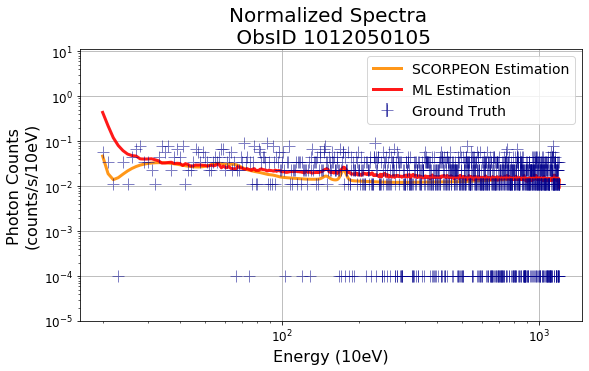

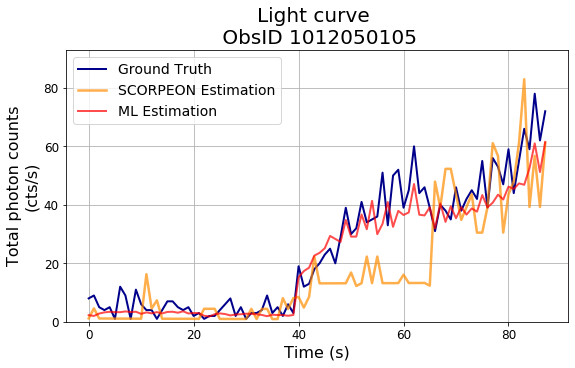

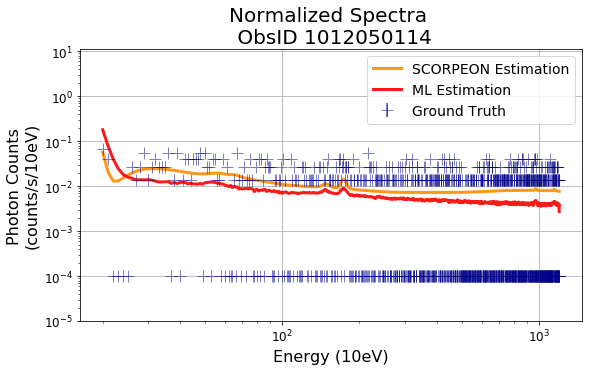

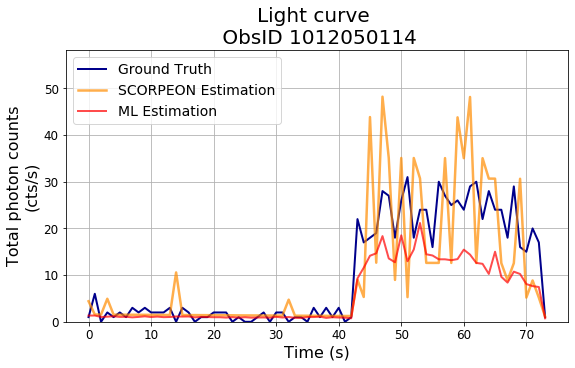

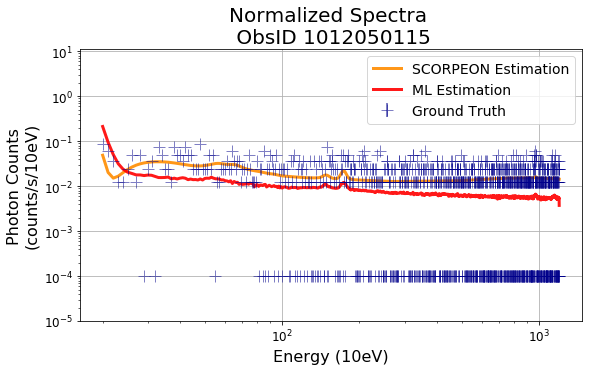

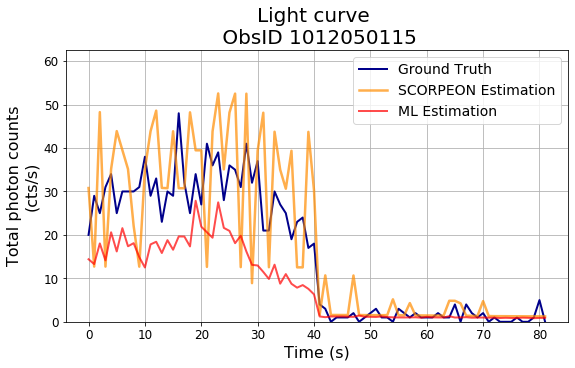

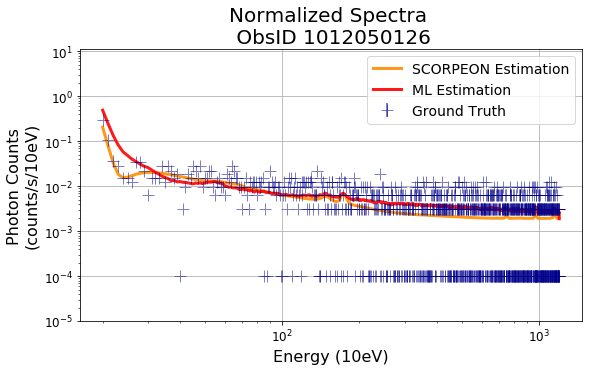

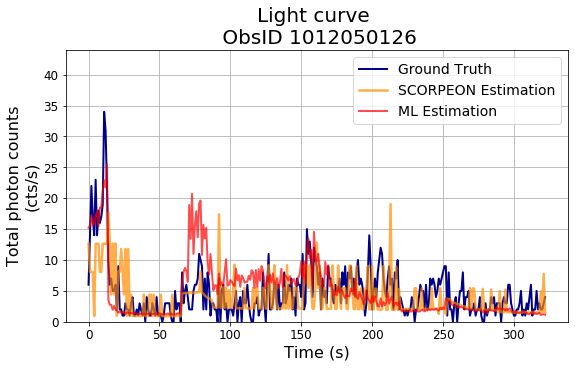

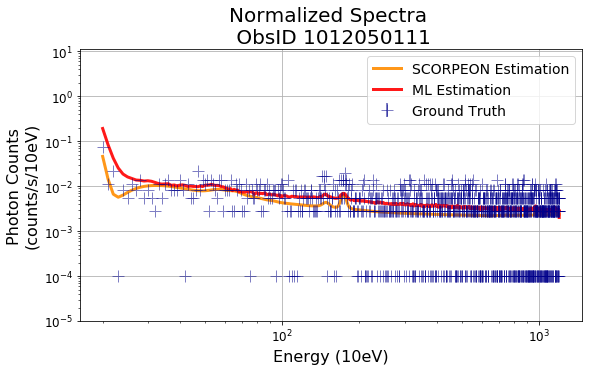

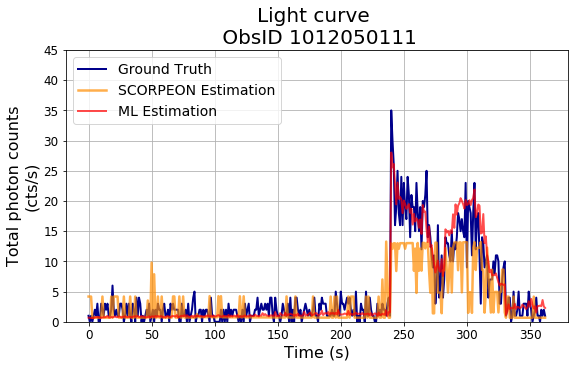

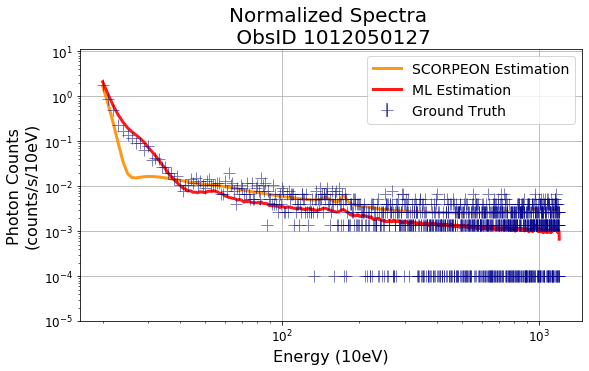

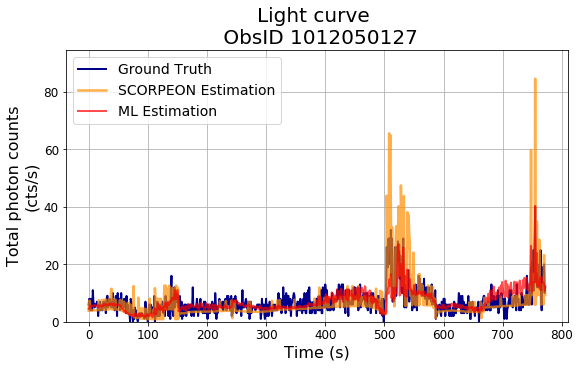

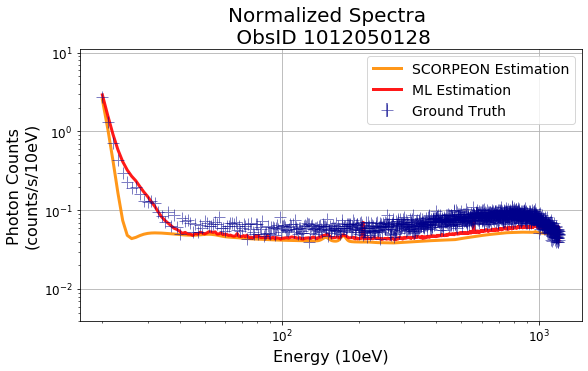

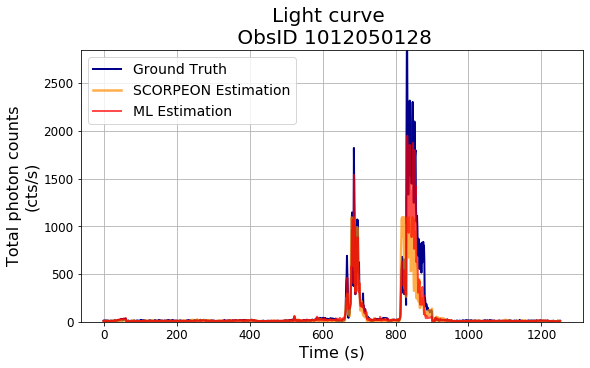

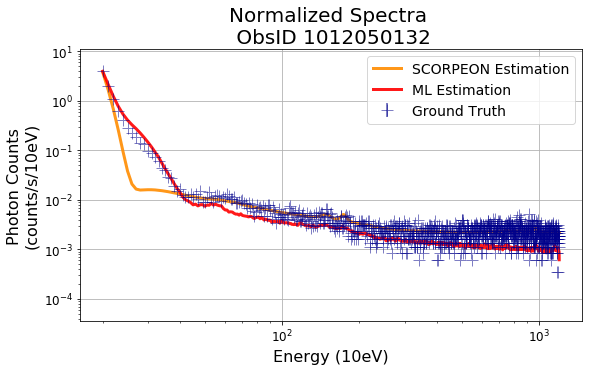

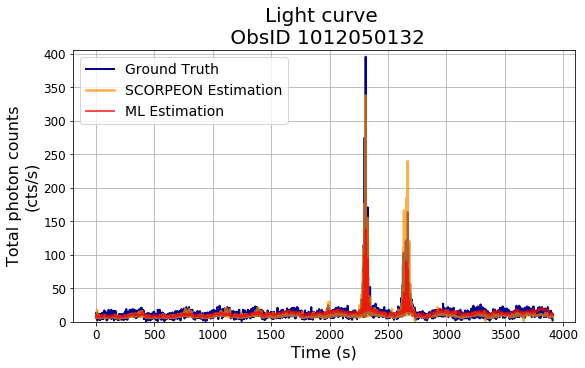

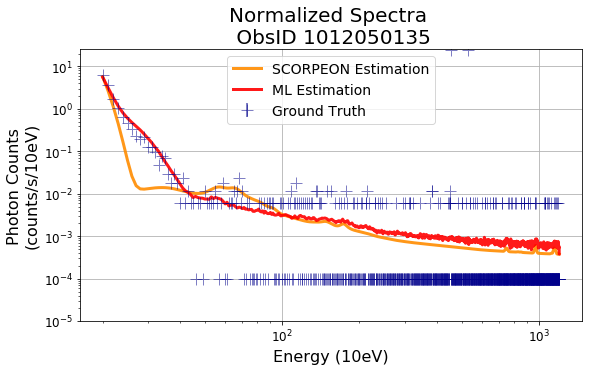

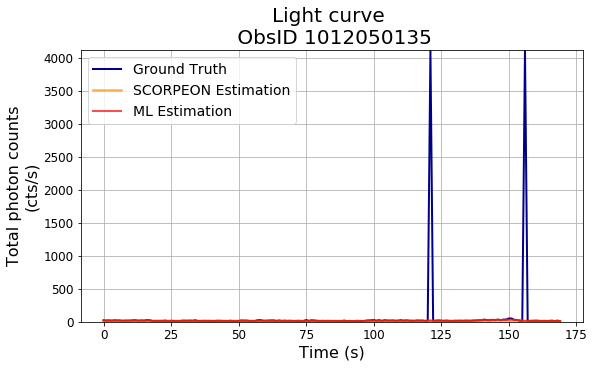

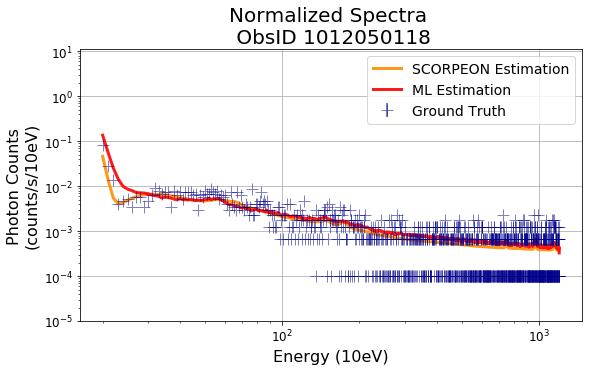

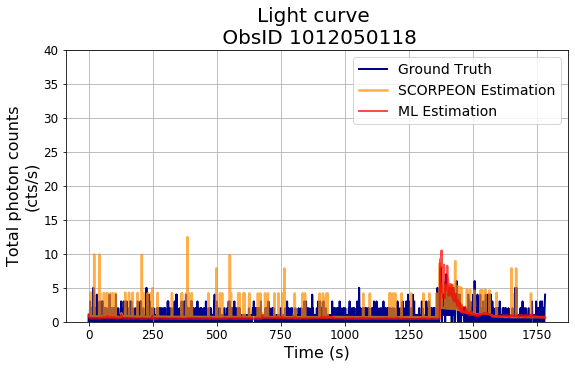

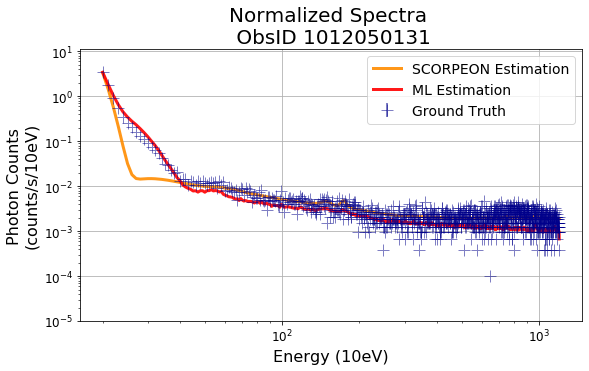

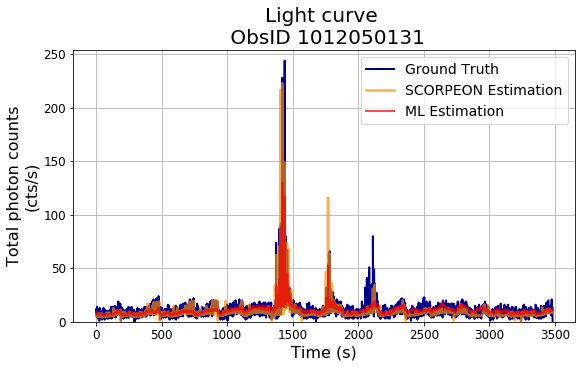

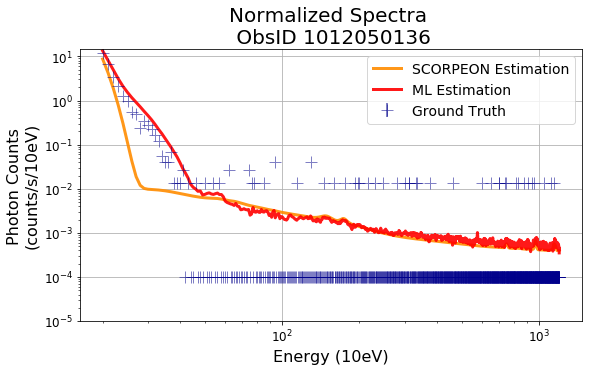

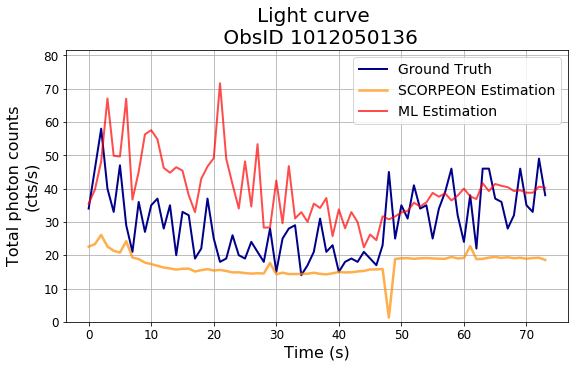

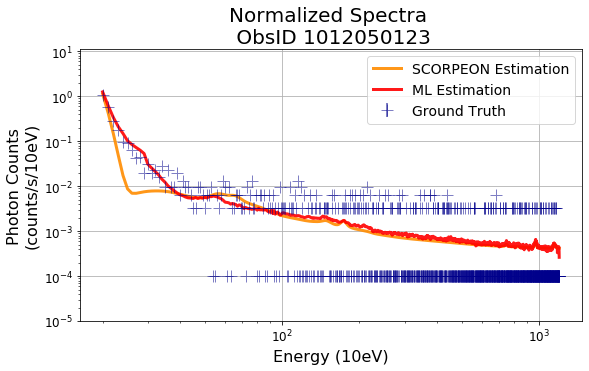

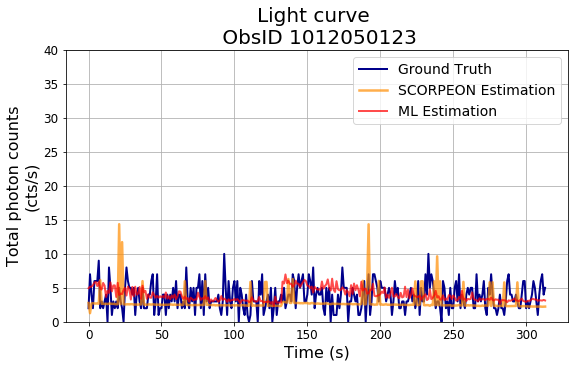

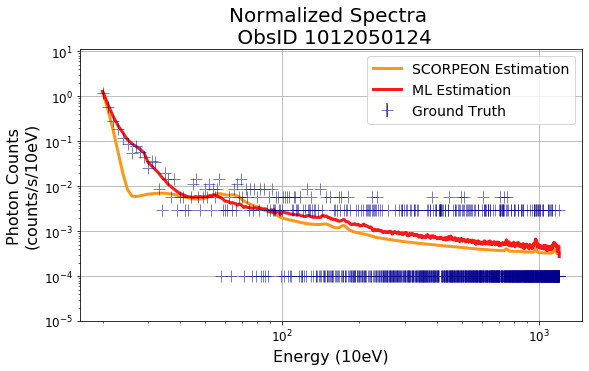

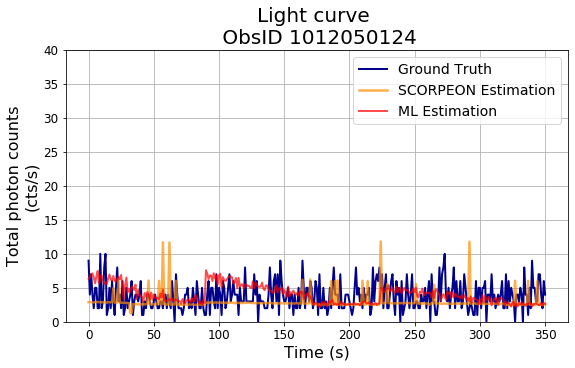

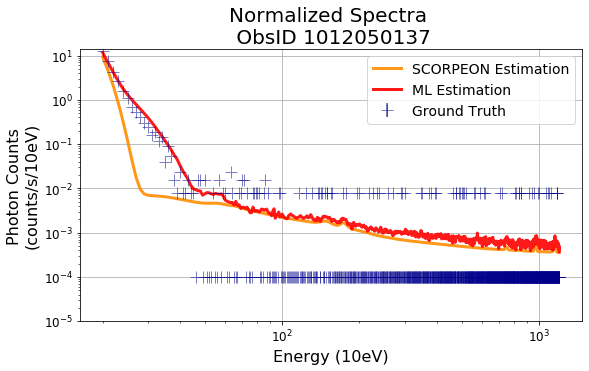

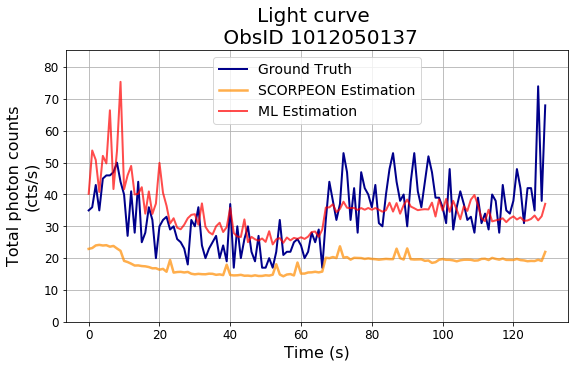

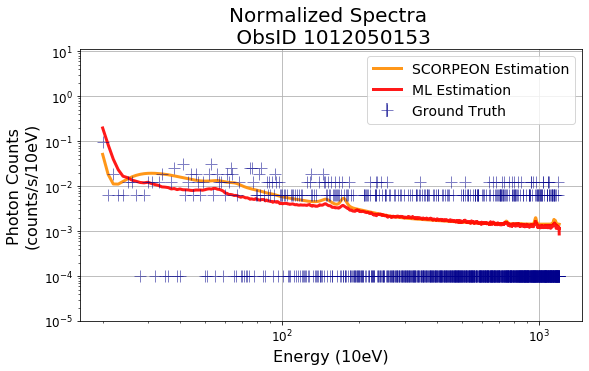

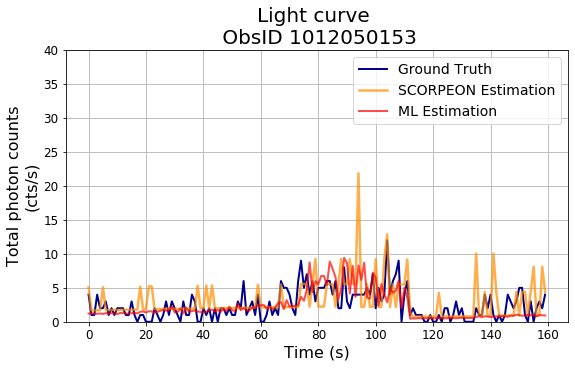

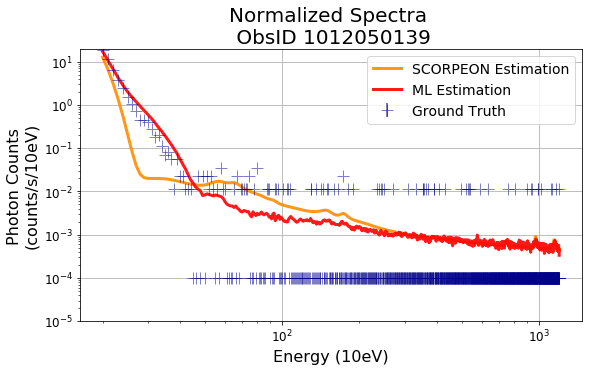

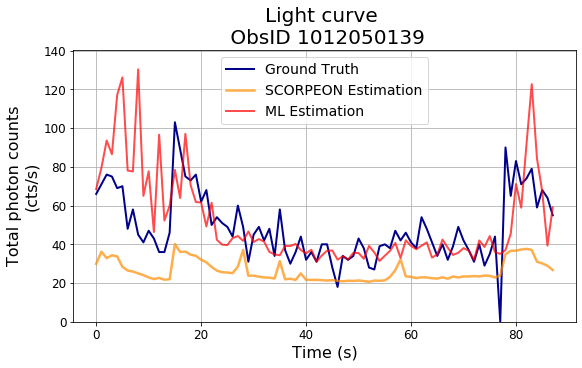

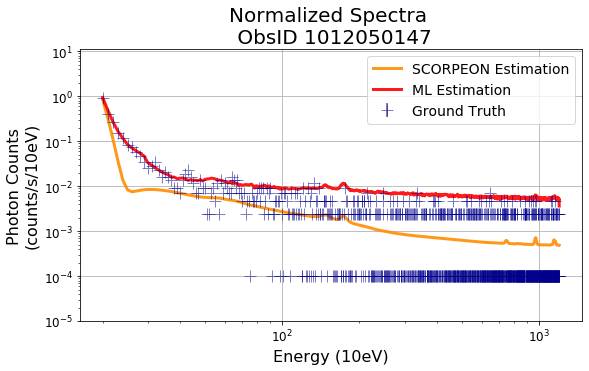

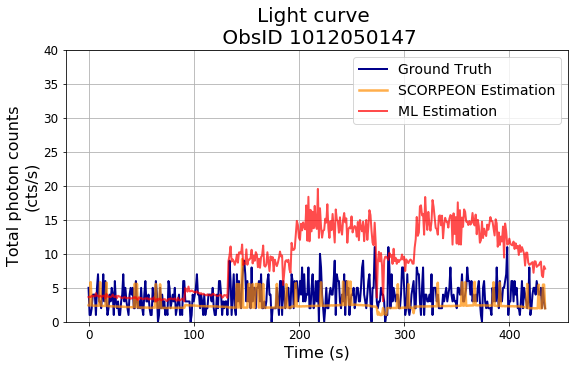

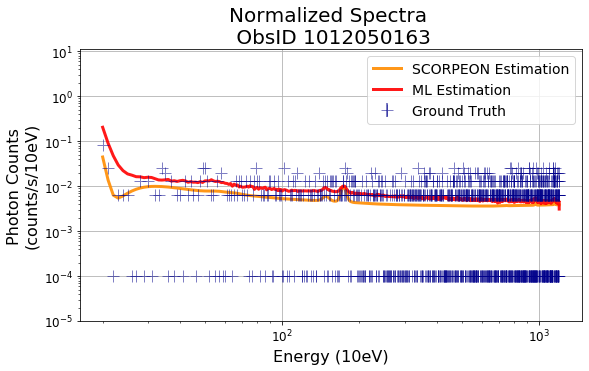

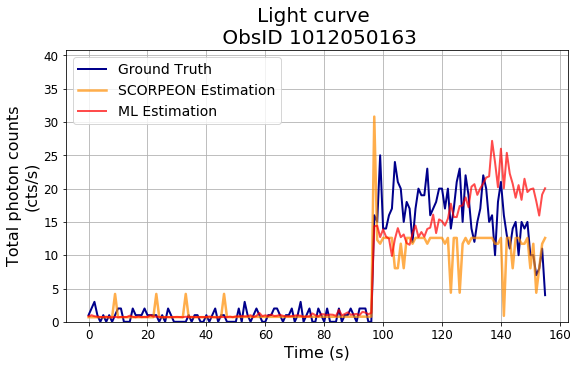

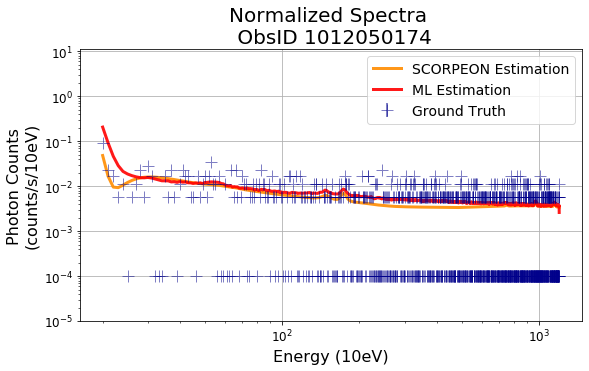

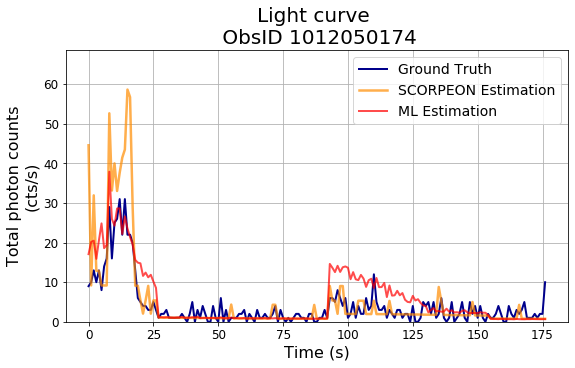

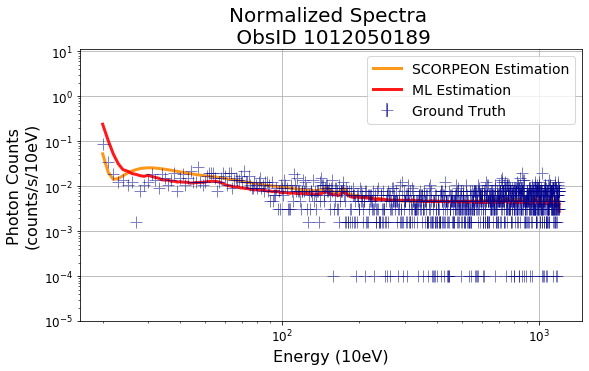

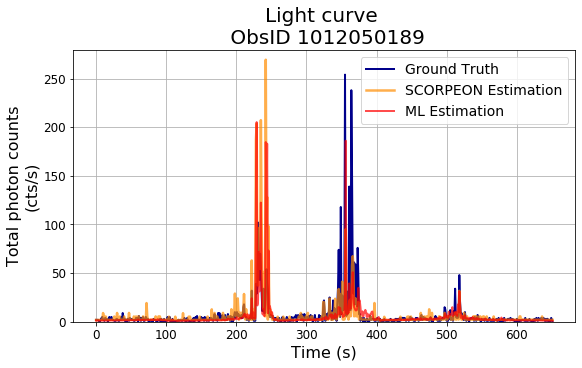

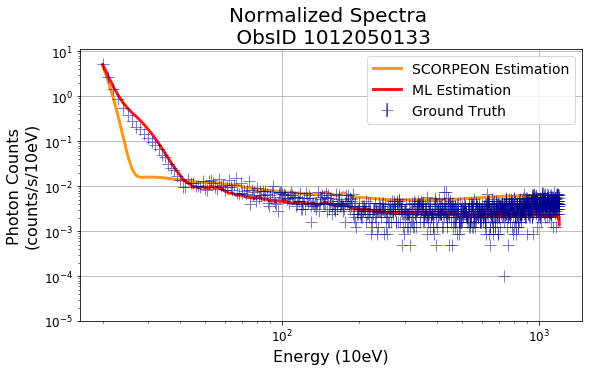

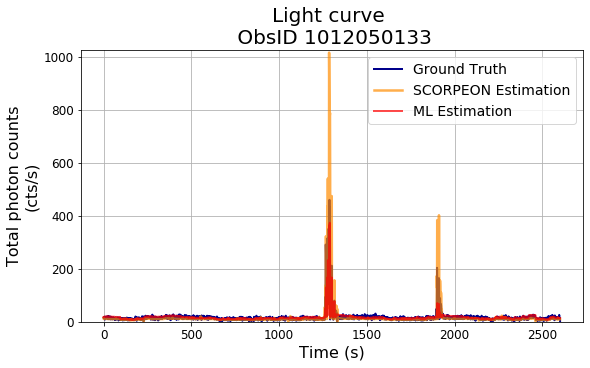

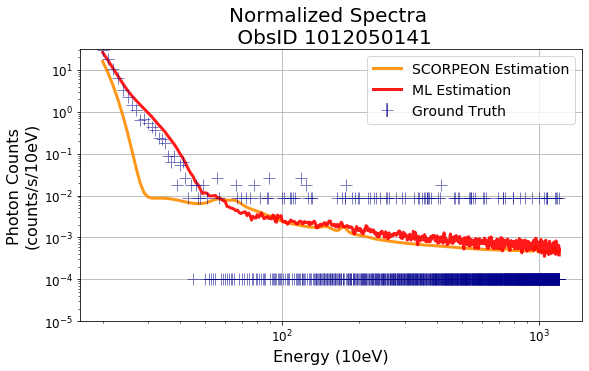

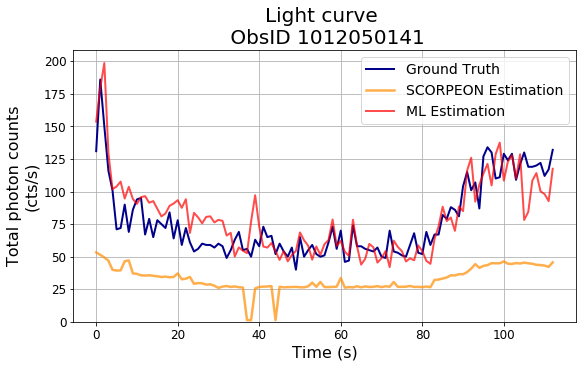

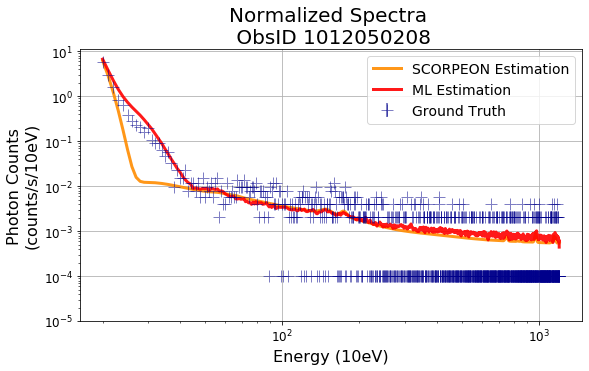

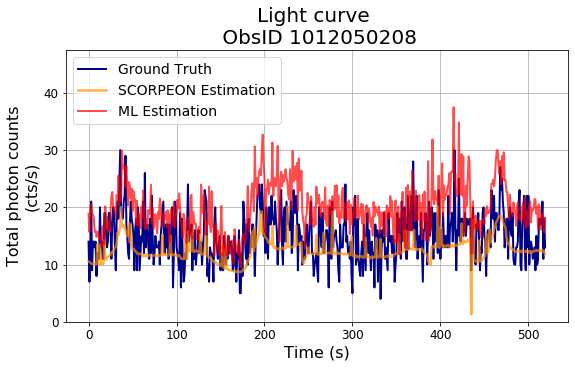

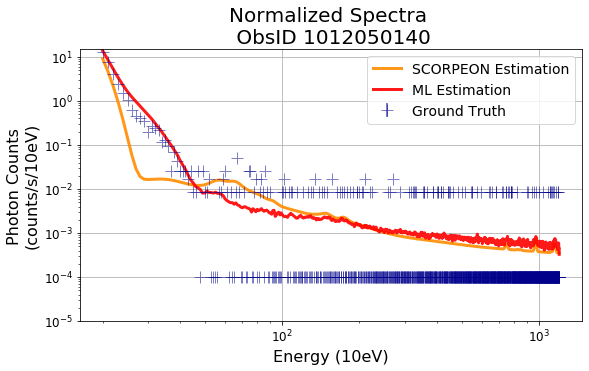

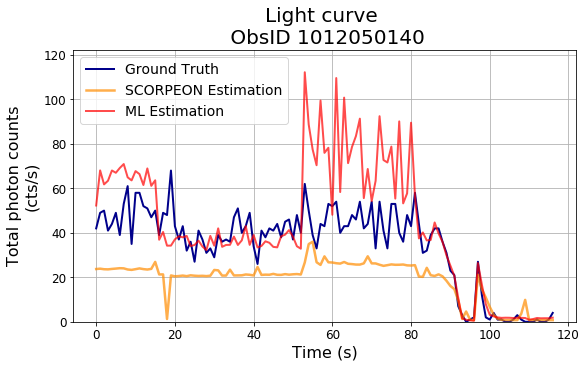

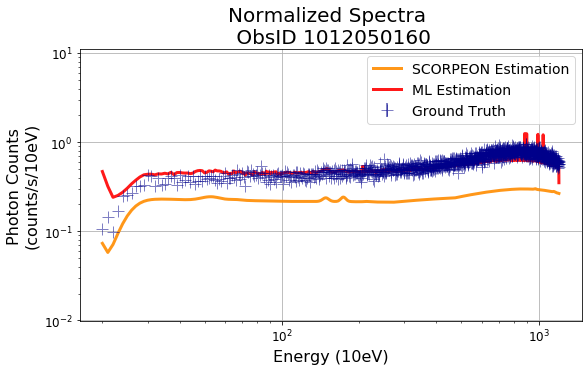

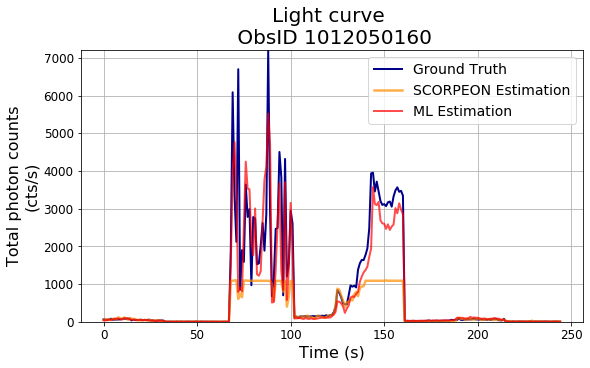

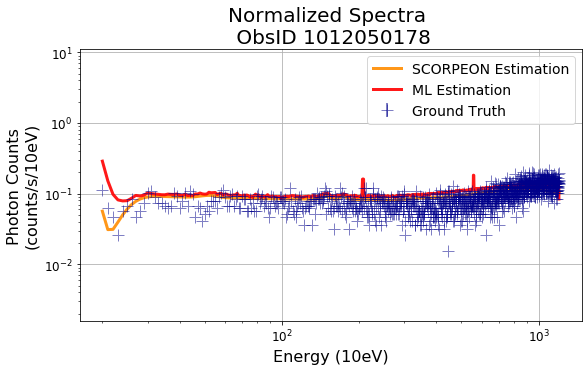

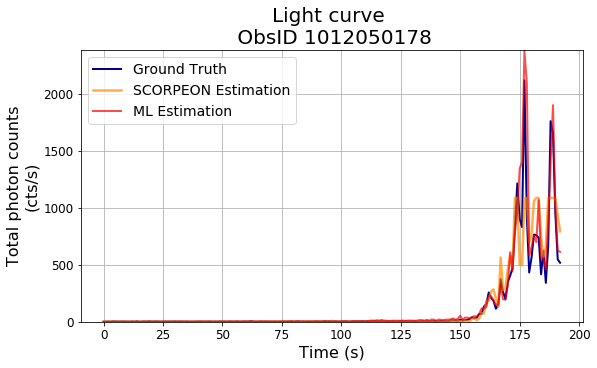

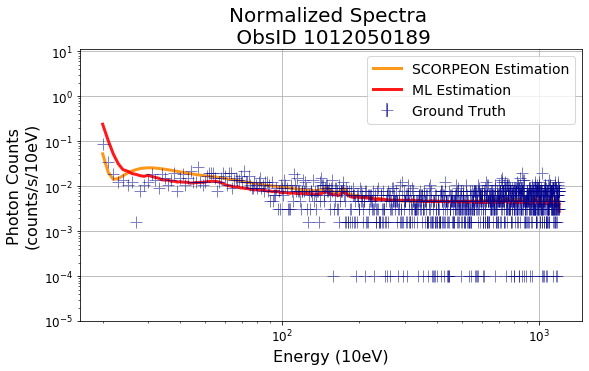

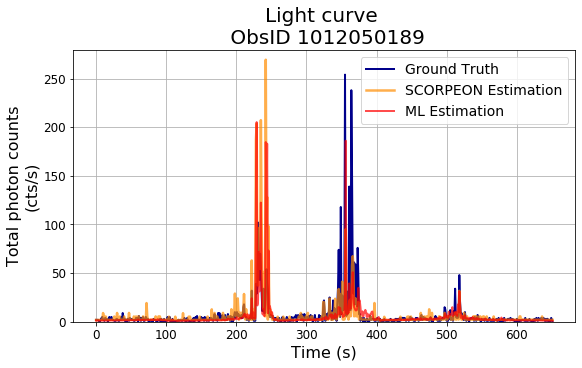

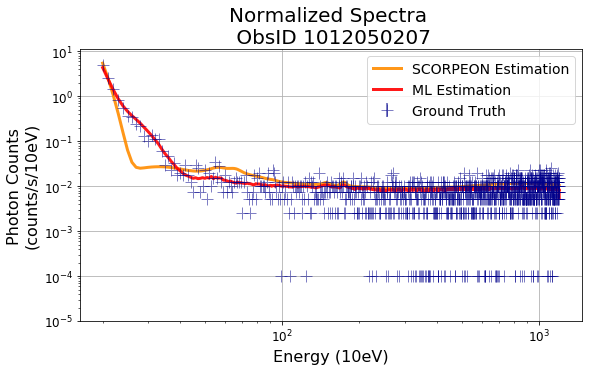

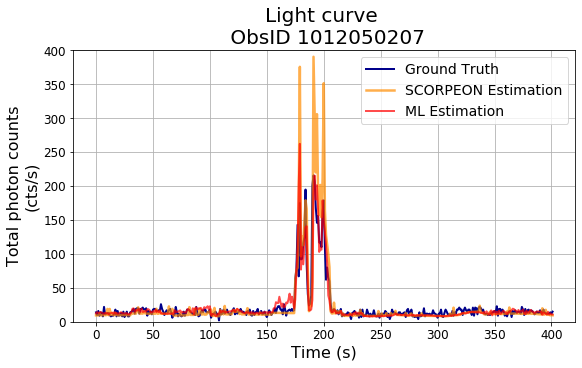

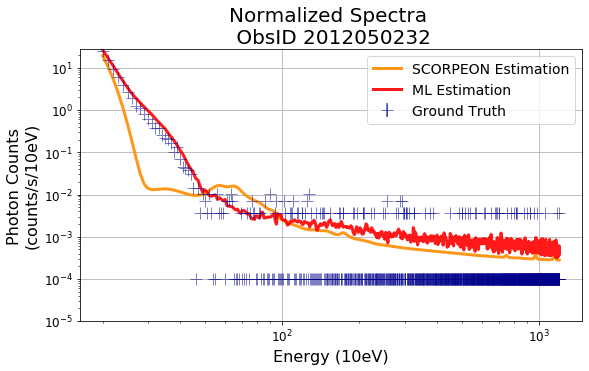

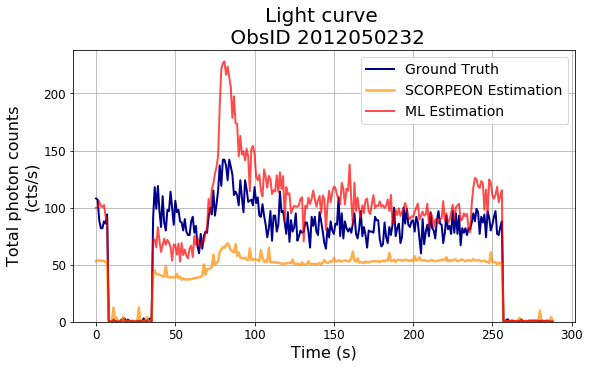

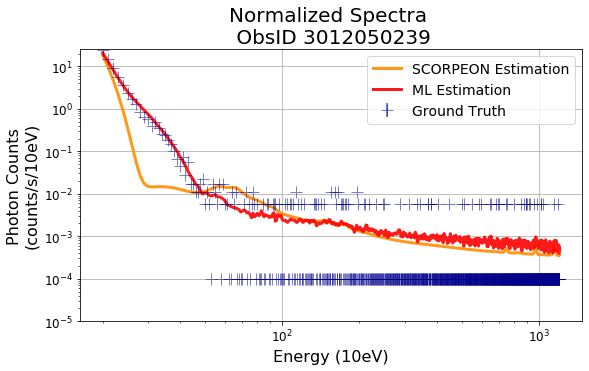

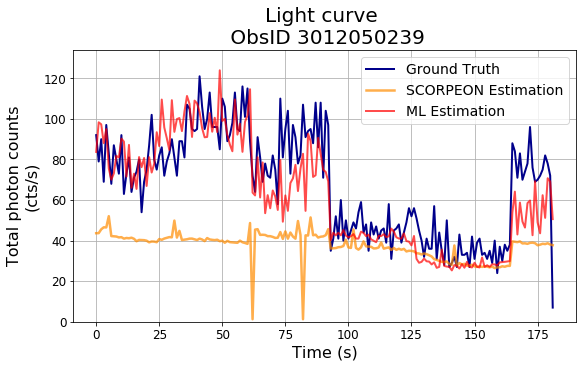

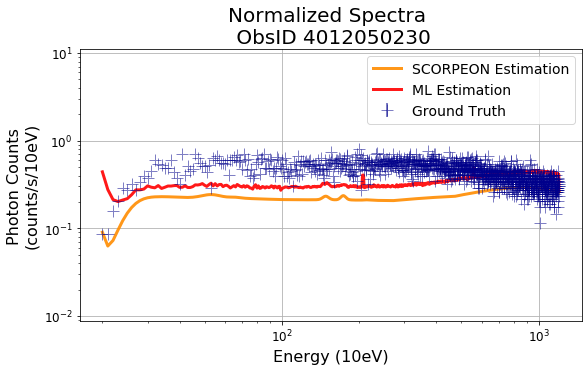

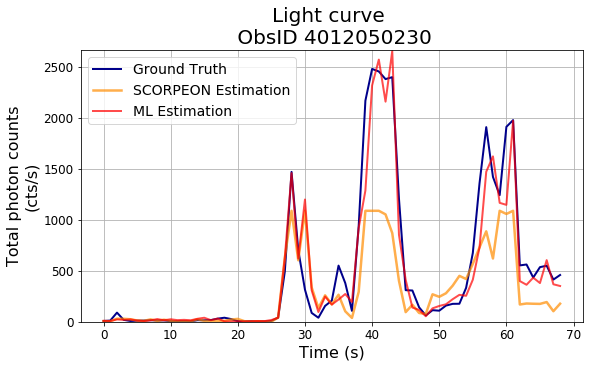

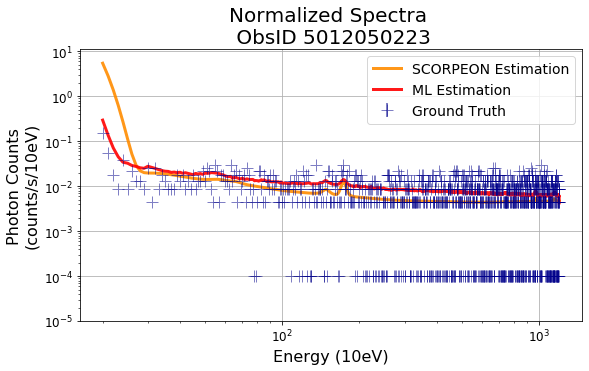

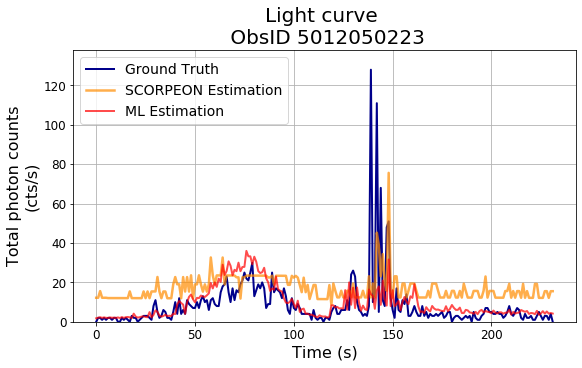

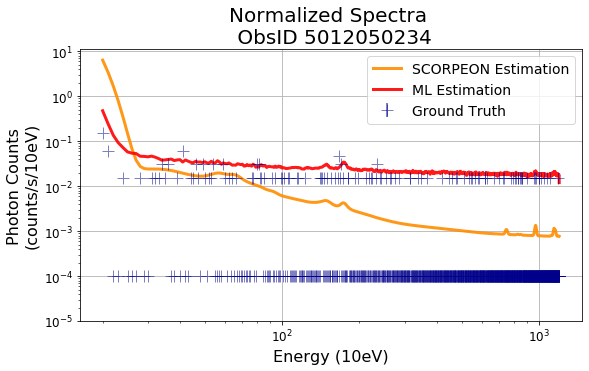

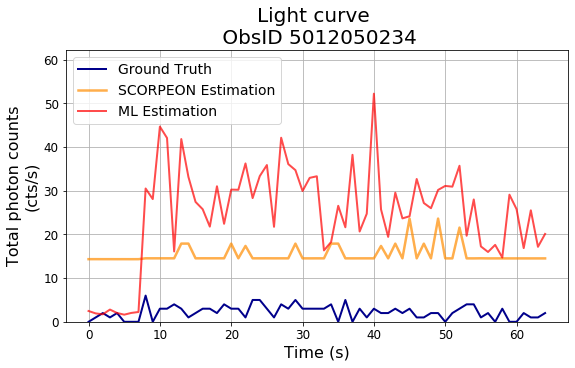

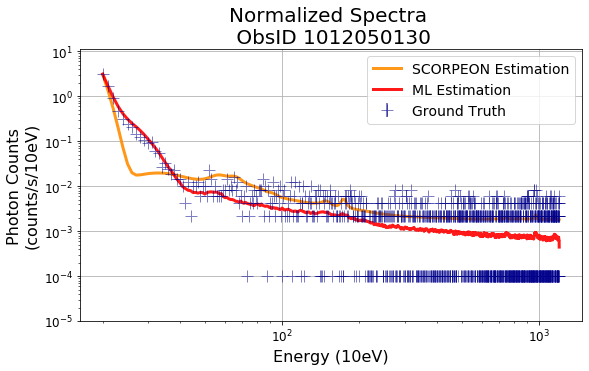

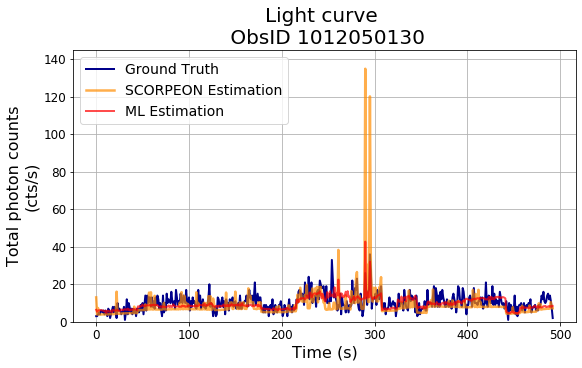

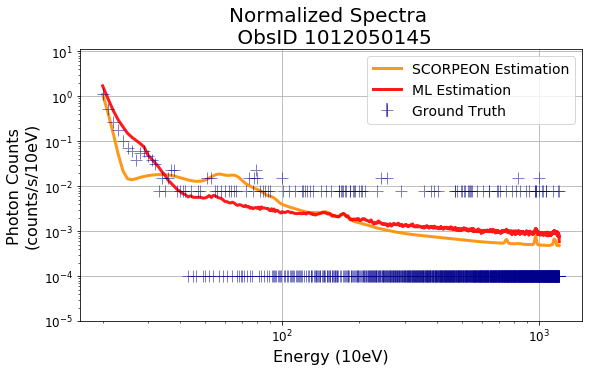

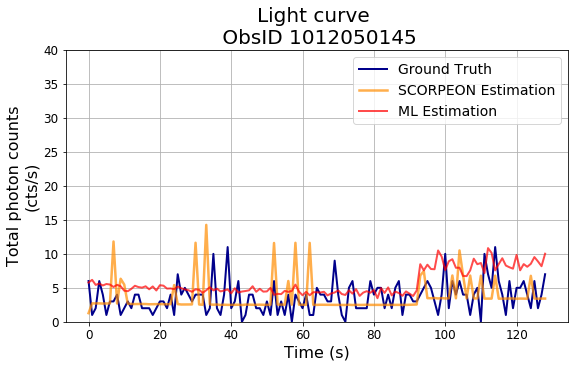

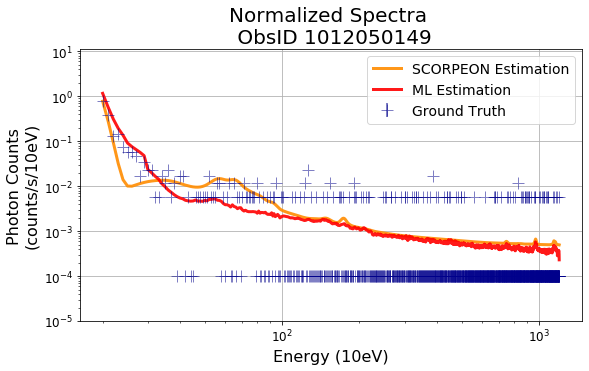

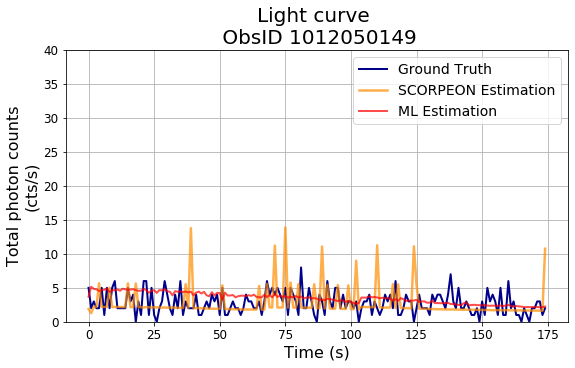

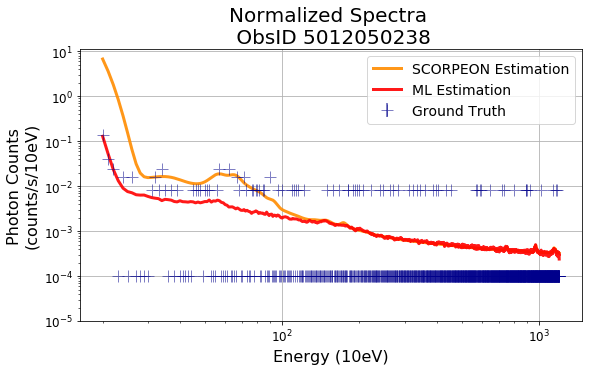

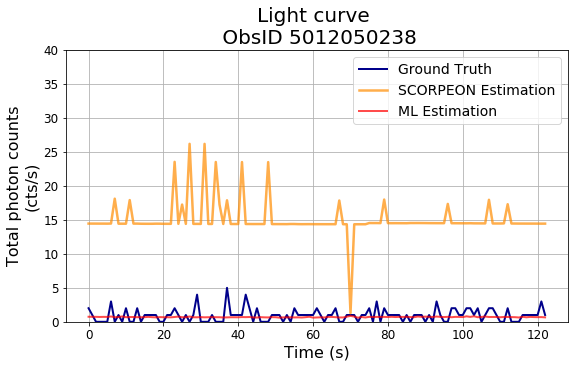

In [21]:
""" Energy bins & Normalized Spectra"""
ebins = list(y_train.columns.astype(int))

""" 
    Extract all events from each ObsID 
    Store results in format:
        obsID => (specs_gt, specs_gt_std, specs_scorps, specs_preds, lc_gt, lc_scorps, lc_preds)
"""
obsid_results = {}
test_indexes = [i for i in y_test.index if i in obsid_df.index]
test_obsid_df = obsid_df.loc[test_indexes]

obsid_list = [1012050105, 1012050114, 1012050115, 1012050126, 
              1012050111, 1012050127, 1012050128, 1012050132, 
              1012050135, 1012050118, 1012050131, 1012050136, 
              1012050123, 1012050124, 1012050137, 1012050153,
              1012050139, 1012050147, 1012050163, 1012050174, 
              1012050189, 1012050133, 1012050141, 1012050208,
              1012050140, 1012050160, 1012050178, 1012050179, 
              1012050189, 1012050207, 2012050232, 3012050239, 
              4012050230, 5012050223, 5012050231, 5012050234, 
              1012050130, 1012050145, 1012050149, 5012050238,]
# obsid_list = [i for i in test_obsid_df.obsID.unique() if i not in obsid_list]

"""==================================================
        Iterate through each ObsID to plot 
        the normalized spectra & lightcurve
=================================================="""
os.system('mkdir -p fig')

for obsid in tqdm(obsid_list):
    ########################################################
    # 1. Store results here
    ########################################################
    obsid_results[obsid] = {}
    
    ###############################################################
    # 2. Extract events from the same ObsID AND is in scorp_specs
    ###############################################################
    # 2a. Get .loc indexes of obsid
    indexes = test_obsid_df[test_obsid_df['obsID'] == obsid].index
    indexes = [idx for idx in indexes if idx in scorp_specs.index]
    
    # Save ObsIDs observations to test_ObsIDs
    X_test.loc[indexes].to_csv(f'test_obsIDs/MKF_params_{obsid}.csv', index=False)
    
    # ignore ObsID with fewer than 60 observations
    if len(indexes) < 60: 
        continue
        
    # 2b. Get .iloc indexes of obsid
    #     + create new test_obsid_df
    #     + create new column call 'iloc_index'
    X_test_iloc = X_test.copy()
    X_test_iloc['index_iloc'] = X_test_iloc.reset_index().index
    indexes_iloc = list(X_test_iloc.loc[indexes]['index_iloc'])

    ########################################################
    # 3. Compute normalized spectra from extracted ObsID
    ########################################################
    obsid_specs_gt = y_test.loc[indexes].mean(axis=0)
    obsid_specs_gt_std = y_test.loc[indexes].std(axis=0)
    obsid_specs_scorps = scorp_specs.loc[indexes].mean(axis=0)
    obsid_specs_preds = predict_normalized_spectra(dnn, 
                                                   X=TensorX_test[indexes_iloc].to(device), 
                                                   model_cluster=model_cluster, 
                                                   models_cluster_2=models_cluster_2,
                                                   cluster_ebins=kmeans_ebins, 
                                                   cluster_ebins_2=kmeans_ebins_2,
                                                   spec_library=spec_library)
    
    ########################################################
    # 4. Compute light curve from extracted ObsID
    ########################################################
    obsid_lc_preds = predict_lightcurve(dnn, 
                                        X=TensorX_test[indexes_iloc].to(device))
    obsid_lc_gt = y_test.loc[indexes].sum(axis=1)
    obsid_lc_gt = np.array(obsid_lc_gt)
    obsid_lc_scorps = scorp_specs.loc[indexes].sum(axis=1)
    obsid_lc_scorps = np.array(obsid_lc_scorps)
    
    ########################################################
    # 5. Plot normalized spectra and light curves
    ########################################################
    # Add 1e-4 to all ground-truth & predictions for visualization purpose
    obsid_specs_gt = obsid_specs_gt + 1e-4
    obsid_specs_preds = obsid_specs_preds + 1e-4
    # Plotting functions
    plotSpecs_freq_domain(ebins, obsid_specs_preds, obsid_specs_gt, 0,
                          obsid_specs_scorps, title=f'Normalized Spectra \n ObsID {obsid}')
    plotSpecs_time_domain(ebins, obsid_lc_preds, obsid_lc_gt, 
                          obsid_lc_scorps, title=f'Light curve \n ObsID {obsid}')